# TODO

- [ ] Checar importância da significância estatística dos coeficientes da regressão
- [ ] Checar quebra estrutural em 1991

# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html	 Clean-checkpoint.ipynb  tabs
Benchmark.ipynb  Clean.ipynb		 Teste.ipynb
Benchmark.pdf	 figs			 VECM_Infla.ipynb
Benchmark.Rmd	 SeriesTemporais.Rproj	 VECM_TxPropria.ipynb


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
#start = datetime.datetime(1992, 1, 1)
end = datetime.datetime(2019, 7, 1)

# Importando dados

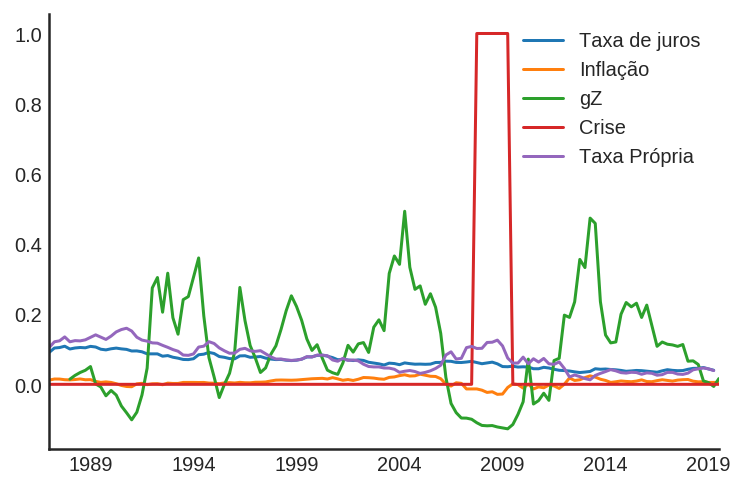

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
2018-06-30,0.045446,0.009007,0.066893,0,0.041386,0.009454,0.001012,-0.004757,0.002623
2018-09-30,0.045669,0.007121,0.056555,0,0.044225,0.002839,-0.010338,-0.001885,0.000223
2018-12-31,0.047846,0.007440,0.009721,0,0.046668,0.002443,-0.046833,0.000318,0.002177
2019-03-31,0.043738,0.005347,0.004754,0,0.044109,-0.002559,-0.004968,-0.002093,-0.004108
2019-06-30,0.040108,0.005519,-0.006007,0,0.039164,-0.004945,-0.010761,0.000172,-0.003631


In [3]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df["Inflação"] = df["Preço dos imóveis"].pct_change(12)
df = df.resample('Q').mean()

df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1
df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria'])

df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv")


df.to_csv(
    "Dados_yeojohnson_ascii.csv", 
    encoding='ascii', 
    header = [
        #'data',
        'invRes',
        'preco',
        'juros',
        'infla',
        'taxap',
        'gz',
        'crise',
          ], 
         )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.tail()

# Funções

## Teste de raíz unitária

In [4]:
def testes_raiz(df=df["gZ"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS série em nível')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print('\nZIVOT ANDREWS série em primeira difenrença')
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF série em nível')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print('\nADF série em primeira diferença')
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS série em nível')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print('\nDFGLS série em primeira diferença')
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS em nível')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print('\nKPSS em primeira diferença')
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron em nível')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print('\nPhillips Perron em primeira diferença')
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

## Teste de Cointegração Engel-Granger e de Johansen

In [5]:
# Teste de cointegração

def cointegracao(ts0, ts1, signif = 0.05, lag=1):
  trends = ['nc', 'c', 'ct', 'ctt']
  for trend in trends:
    print(f"\nTestando para lag = {lag} e trend = {trend}")
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
      print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
      print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')
    
def testes_coint(series, maxlag=8):
    for i in range(1, maxlag):
        print(50*'=')
        cointegracao(
            ts0=series.iloc[:, 0],
            ts1=series.iloc[:, 1:],
            signif=0.05,
            lag=i
        )
        print("\nTESTE DE JOHANSEN\n")
        rank_sel = select_coint_rank(endog=series, k_ar_diff=i, det_order=1).rank
        print(f'Para lag = {i}, Rank = {rank_sel}')
        print(10*'=')

## Análise de resíduos: Ljung-Box e Box-Pierce

In [6]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1] < signif
    for j in range(k):
      print("Reject H0 on lag " ,j+1,"? ", result[j])
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
        sns.set_context('paper')
        fig, ax = plt.subplots(1,2, figsize=(10,8))

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [7]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 2)
        ax[i,0].set_xlabel(f'{series[1]} defasada em {trimestres[i]} trimestres')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 2)
        ax[i,1].set_xlabel(f'{series[0]} defasada em {trimestres[i]} trimestres')

# Teste de quebra estrutural

In [8]:
%%R -i df
library(strucchange)
library(urca)
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- ts(data = df, start = c(1987,01), frequency = 4)
bp_ts <- breakpoints(Juros ~ 1, data=df)
print("Testando quebra estrutural para Taxa de juros das hipotecas")
print(summary(bp_ts))

bp_ts <- breakpoints(gZ ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa de crescimento dos imóveis")
print(summary(bp_ts))

bp_ts <- breakpoints(TaxaP ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa Própria")
print(summary(bp_ts))

bp_ts <- breakpoints(Infla ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Inflação")
print(summary(bp_ts))

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich



[1] "Testando quebra estrutural para Taxa de juros das hipotecas"

	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = Juros ~ 1, data = df)

Breakpoints at observation number:
                      
m = 1            78   
m = 2            67 85
m = 3   18       67 85
m = 4   18 36    67 85
m = 5   18 36 54 73 91

Corresponding to breakdates:
                                               
m = 1                           2006(2)        
m = 2                           2003(3) 2008(1)
m = 3   1991(2)                 2003(3) 2008(1)
m = 4   1991(2) 1995(4)         2003(3) 2008(1)
m = 5   1991(2) 1995(4) 2000(2) 2005(1) 2009(3)

Fit:
                                                   
m   0       1       2       3       4       5      
RSS   6.608   5.957   4.278   4.278   4.278   4.278
BIC  -3.113  -6.411 -38.155 -28.499 -18.842  -9.186
[1] "========================="
[1] "Testando quebra estrutural para Taxa de crescimento dos imÃ³veis"

	 Optimal (m+1)-segment part

Selecionando série para depois de 1991

In [9]:
df = df["1992-01-01":]

# Teste de raíz unitária

## Investimento residencial ($g_Z$)

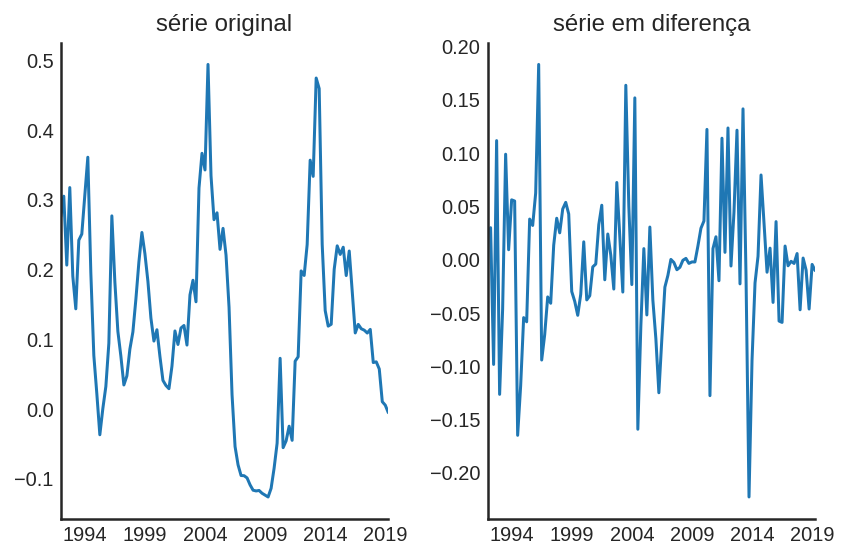

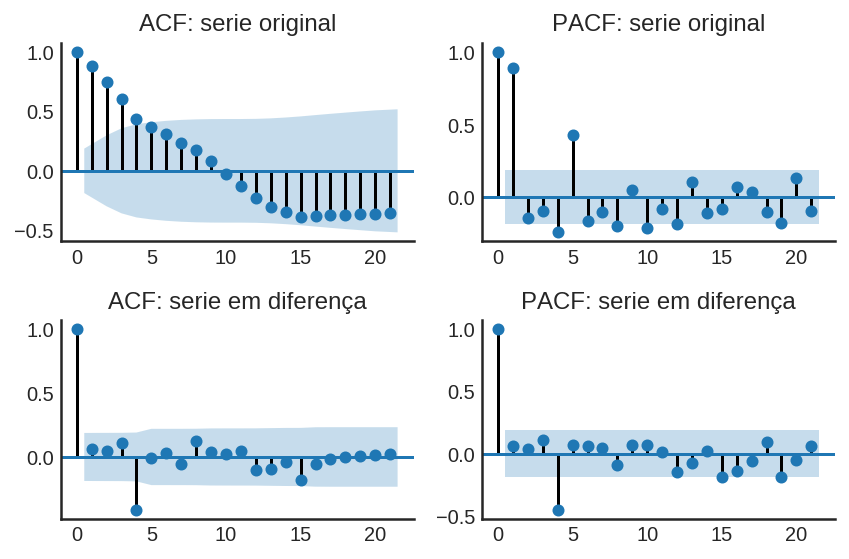


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -3.206
P-value                         0.838
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -7.727
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.406
P-value 

In [10]:
testes_raiz(df=df['gZ'])

**Conclusão:** Série  não é fracamente estacionária.

## Taxa própria

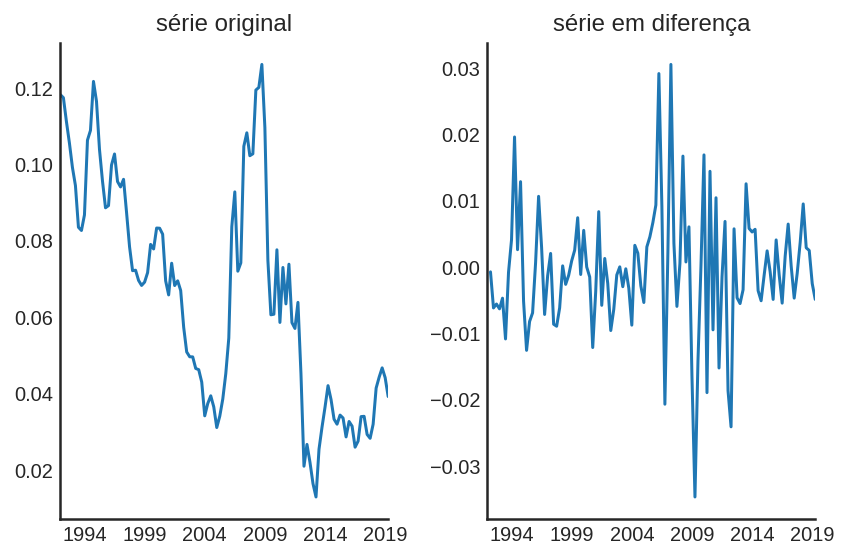

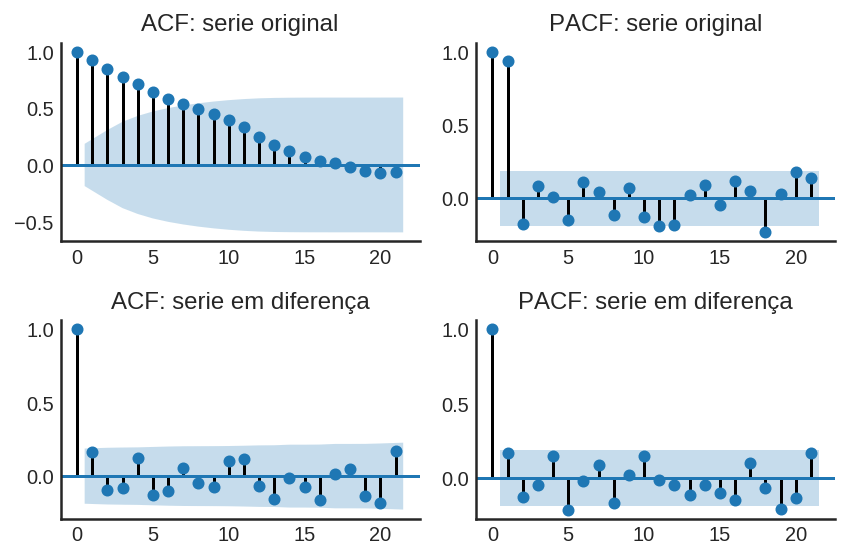


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.517
P-value                         0.114
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -8.320
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.323
P-value 

In [11]:
testes_raiz(df['Taxa Própria'])

**Conclusão:** Será tomada em primeira diferença.

## Inflação

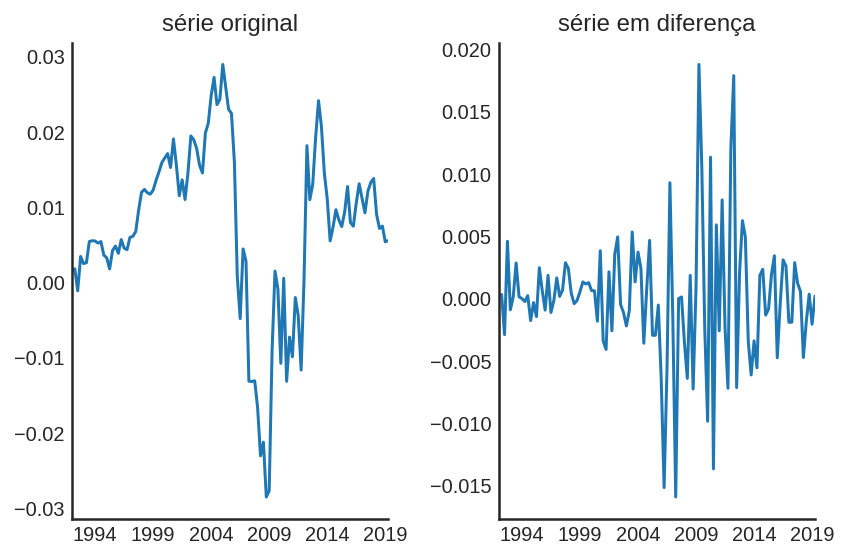

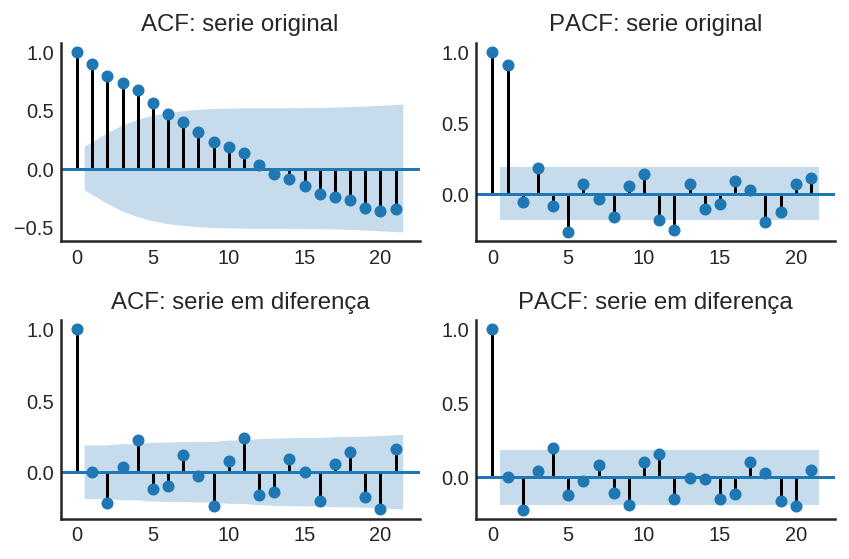


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -5.056
P-value                         0.024
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                -10.104
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.617
P-value 

In [12]:
testes_raiz(df['Inflação'])

## Taxa de juros das hipotecas

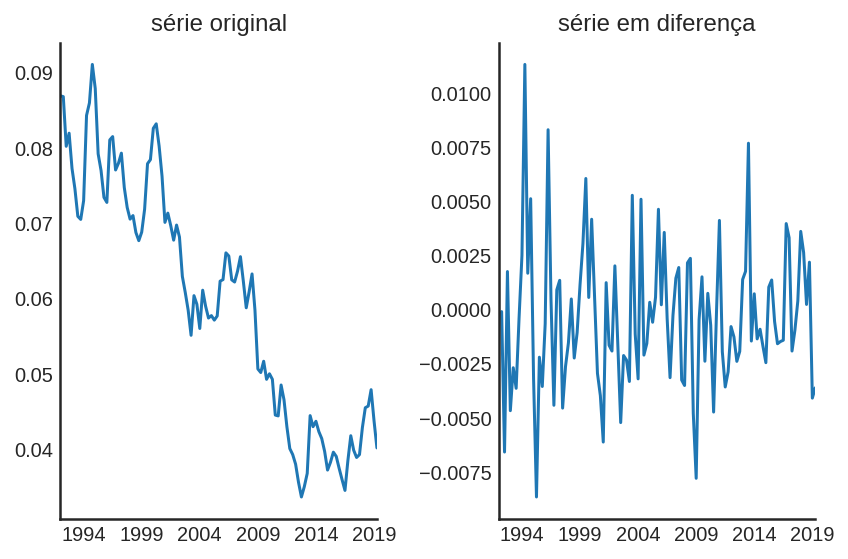

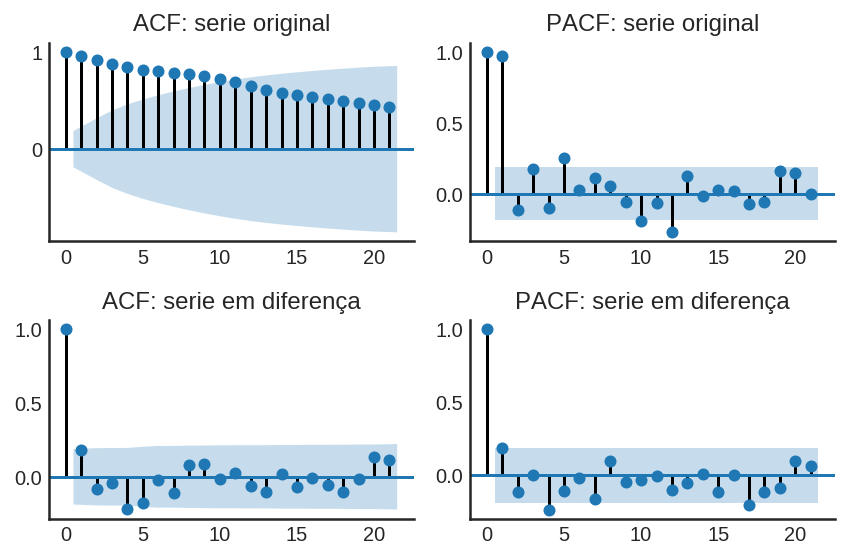


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.941
P-value                         0.073
Lags                                3
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -6.814
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic          

In [13]:
testes_raiz(df['Taxa de juros'], original_trend='ct')

# Cointegração

## $g_Z$ e Taxa Própria

In [14]:
testes_coint(series=df[['gZ', 'Taxa Própria']], maxlag=9)


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.619887
p-value: 0.070102
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.004305
p-value: 0.109186
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.315541
p-value: 0.000231
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.447755
p-value: 0.000586
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Para lag = 1, Rank = 2

Testando para lag = 2 e tr

## $g_Z$, Inflação e taxa de juros

In [15]:
testes_coint(series=df[['gZ', 'Inflação', 'Taxa de juros']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.203346
p-value: 0.003197
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.303434
p-value: 0.009711
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.720985
p-value: 0.000157
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.936312
p-value: 0.000247
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Para lag = 1, Rank = 3

Testando para lag = 2 e trend = nc
Null Hypothes

## $g_Z$ e Inflação

In [16]:
testes_coint(series=df[['gZ', 'Inflação']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.836432
p-value: 0.001967
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.290165
p-value: 0.002652
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.263676
p-value: 0.012321
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.205067
p-value: 0.043593
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Para lag = 1, Rank = 2

Testando para lag = 2 e trend = nc
Null Hypothes

# VECM

VECM: $g_Z$, Inflação e Juros exógeno

## Ordem do modelo

In [17]:
from statsmodels.tsa.vector_ar.vecm import select_order

det = 'cili'
order_vec = select_order(
    df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    maxlags=15, deterministic=det)

with open('./tabs/VECM_lag_order.tex','w') as fh:
    fh.write(order_vec.summary().as_latex_tabular(tile = "Selação ordem do VECM"))

order_vec.summary()

,AIC,BIC,FPE,HQIC
0,-14.96,-14.69*,3.186e-07,-14.85*
1,-14.99,-14.61,3.100e-07,-14.83
2,-14.96,-14.47,3.196e-07,-14.76
3,-14.98,-14.39,3.112e-07,-14.74
4,-15.09,-14.39,2.806e-07,-14.81
5,-15.09,-14.28,2.802e-07,-14.77
6,-15.12*,-14.20,2.735e-07*,-14.75
7,-15.09,-14.06,2.840e-07,-14.67
8,-15.05,-13.92,2.948e-07,-14.59
9,-14.98,-13.73,3.188e-07,-14.48


## Estimação

In [18]:
model = VECM(
    endog = df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    k_ar_diff=8,
    deterministic=det, 
)
results = model.fit()

with open('./tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

print(results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Taxa Própria
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.Taxa Própria     0.2653      0.122      2.180      0.029       0.027       0.504
L1.gZ              -0.0135      0.019     -0.697      0.486      -0.052       0.025
L2.Taxa Própria    -0.0614      0.121     -0.509      0.610      -0.298       0.175
L2.gZ               0.0128      0.020      0.656      0.512      -0.025       0.051
L3.Taxa Própria    -0.1763      0.119     -1.476      0.140      -0.410       0.058
L3.gZ              -0.0065      0.019     -0.351      0.725      -0.043       0.030
L4.Taxa Própria     0.2522      0.115      2.189      0.029       0.026       0.478
L4.gZ               0.0052      0.018      0.285      0.776      -0.030       0.041
L5.Taxa Própria    -0.2778      0.110     -2.534      0.011      -0.

## Análise dos resíduos


PÓS ESTIMAÇÂO



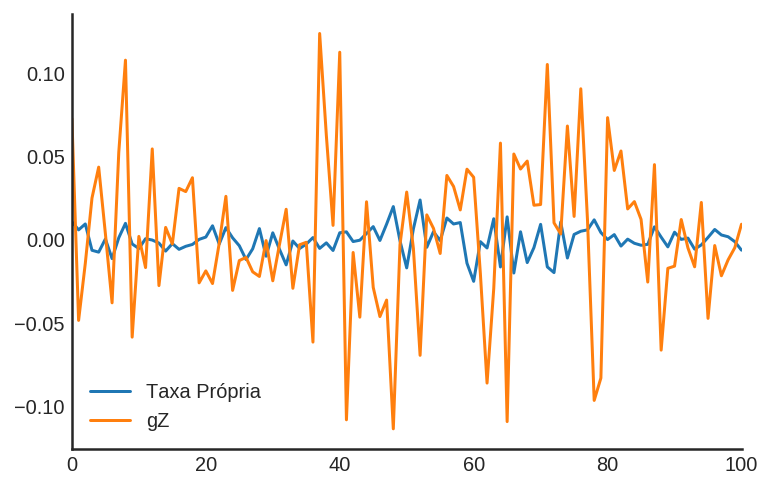

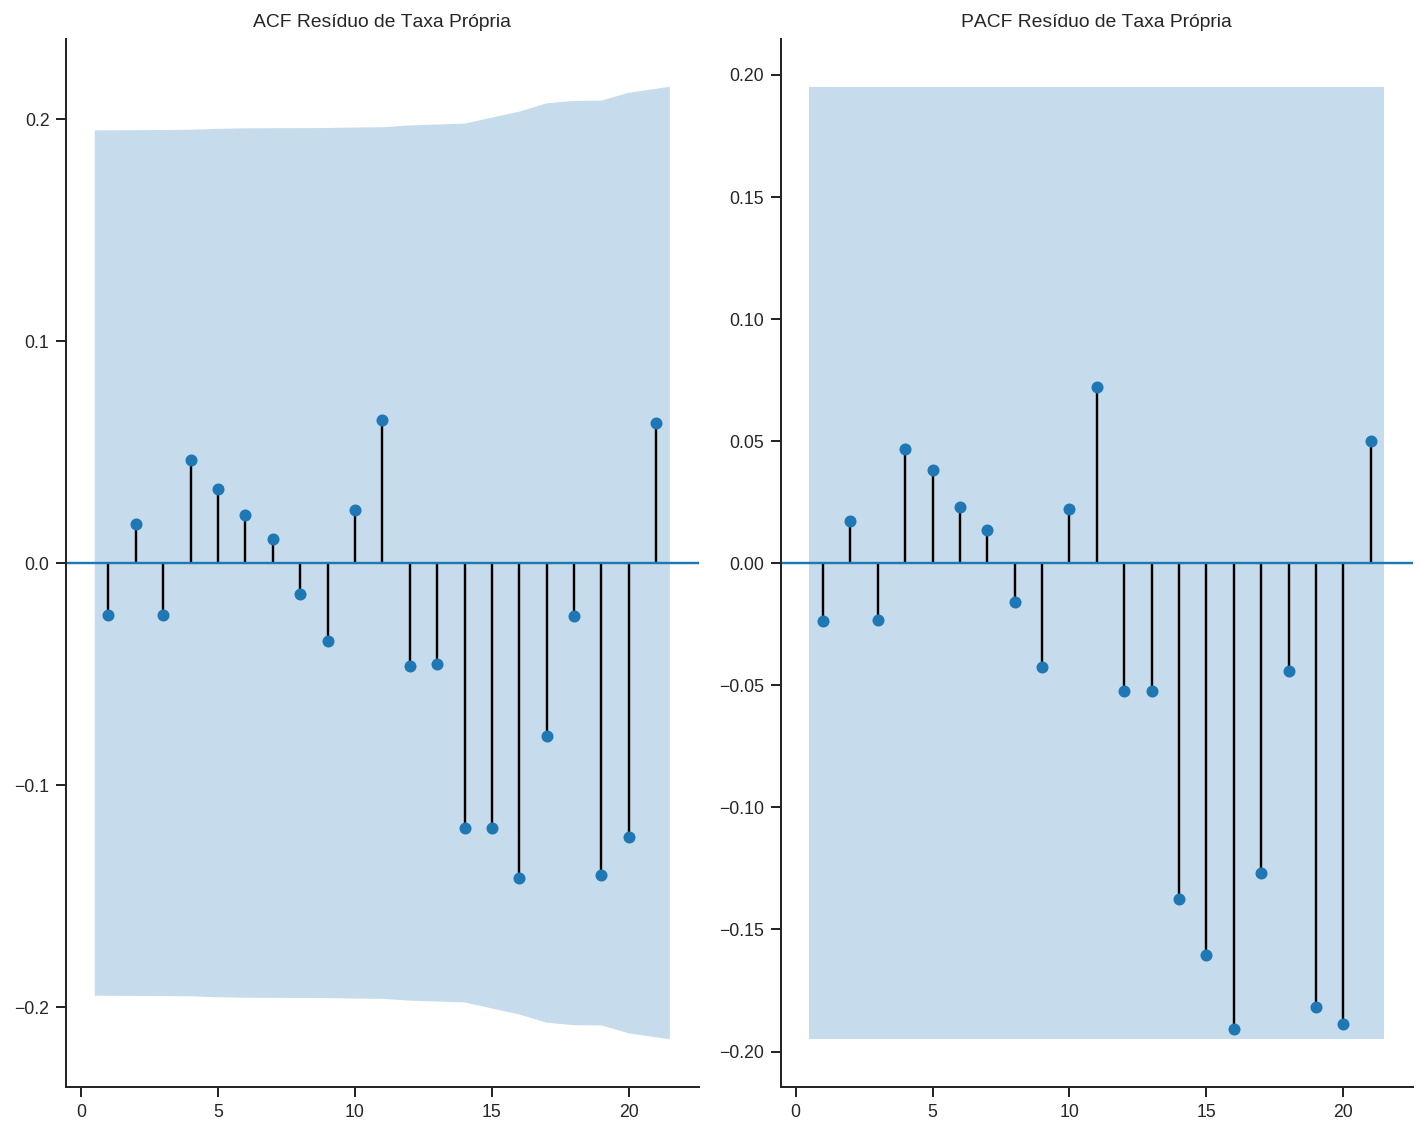

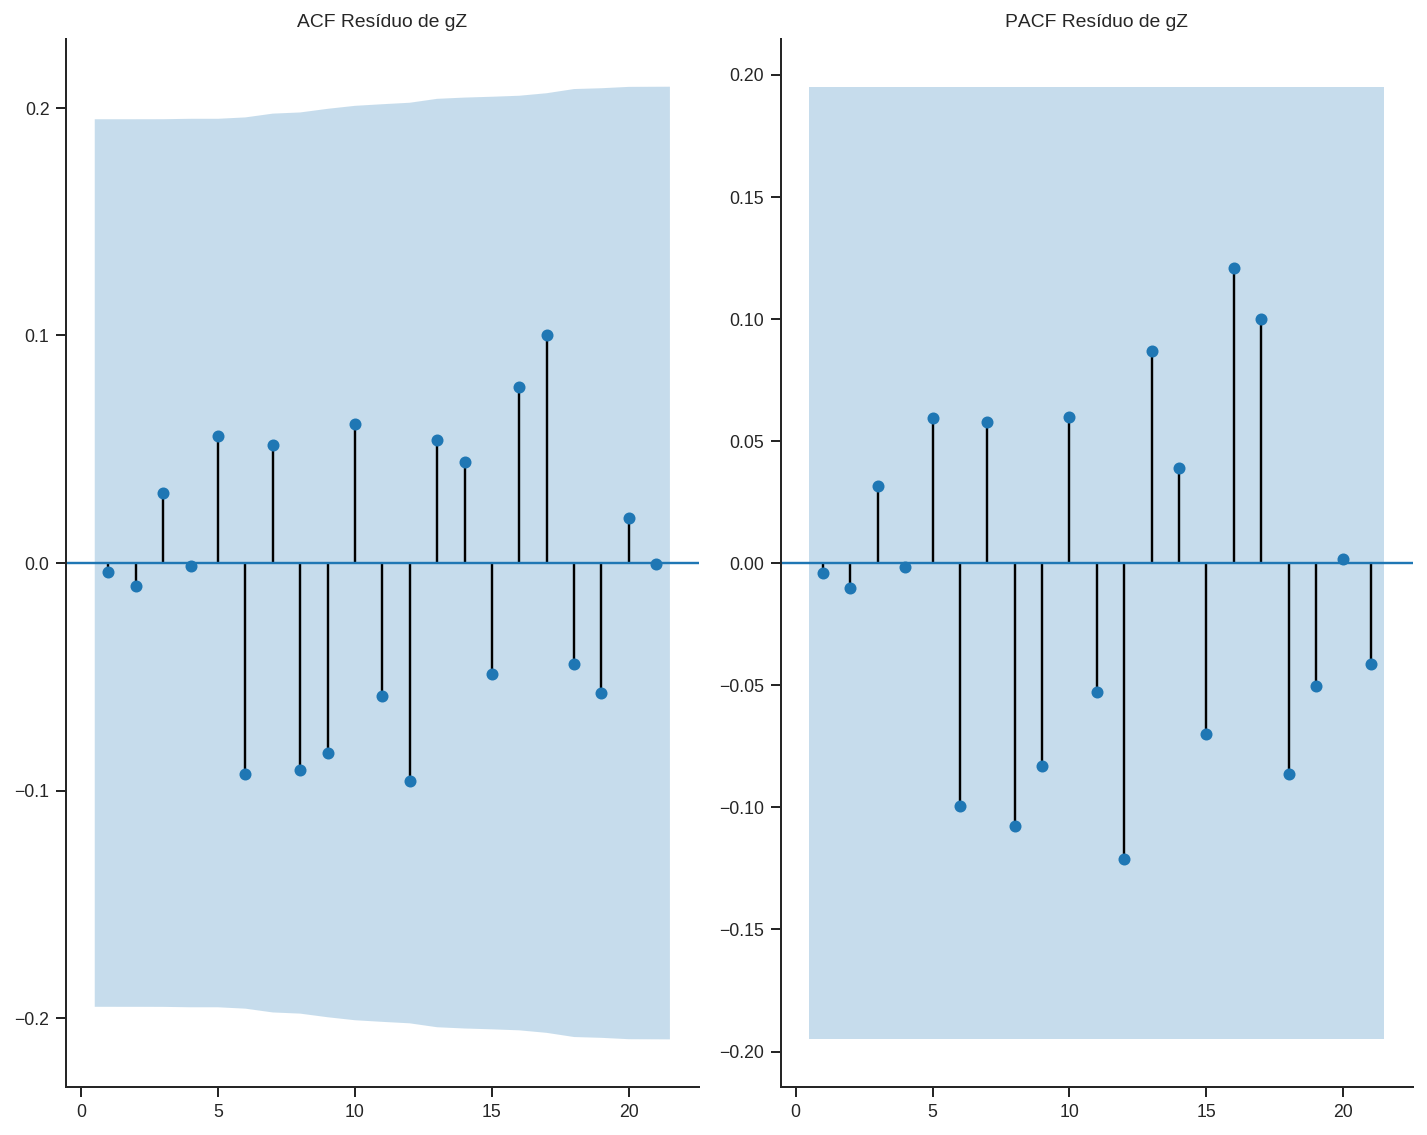

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         24.77          38.89   0.532 26
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         27.51          38.89   0.383 26
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  TAXA PRÓPRIA . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?

In [19]:
print(60*"=")
print("\nPÓS ESTIMAÇÂO\n")
residuals = analise_residuos(results=results)
print(60*"=")

## Função impulso resposta ortogonalizada

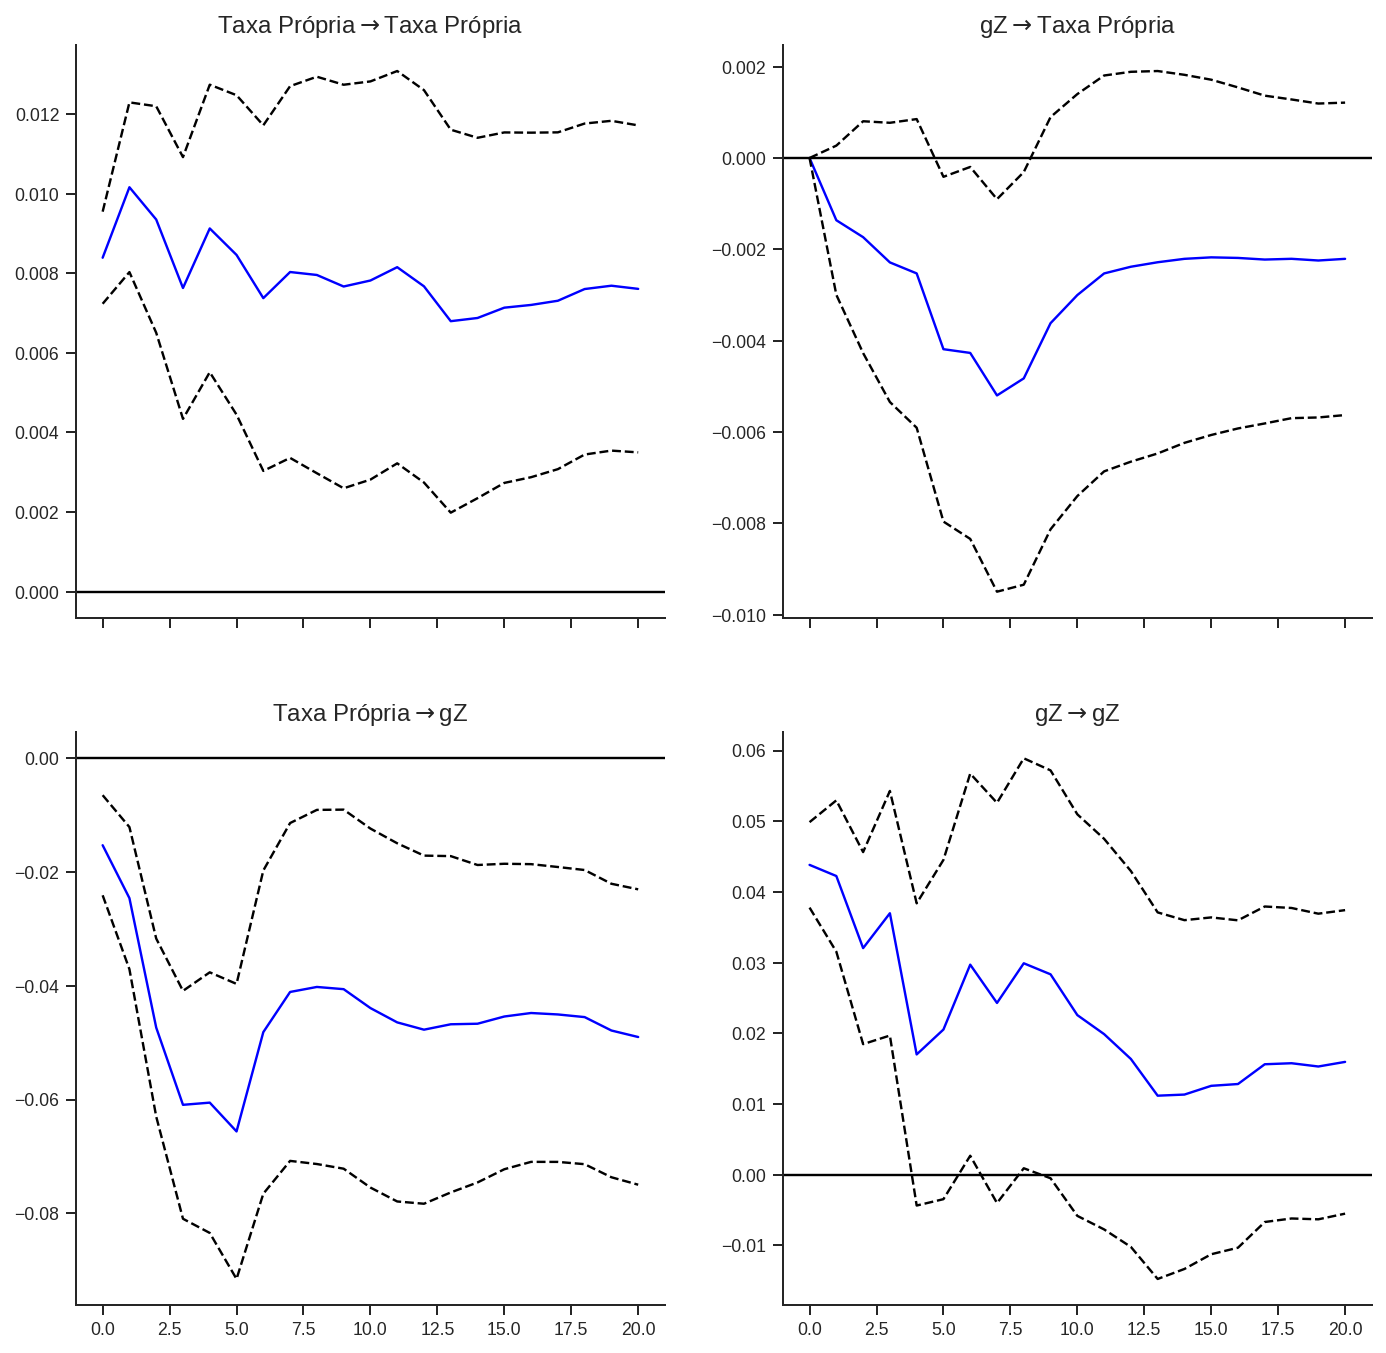

In [20]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Função impulso resposta não-ortogonalizada

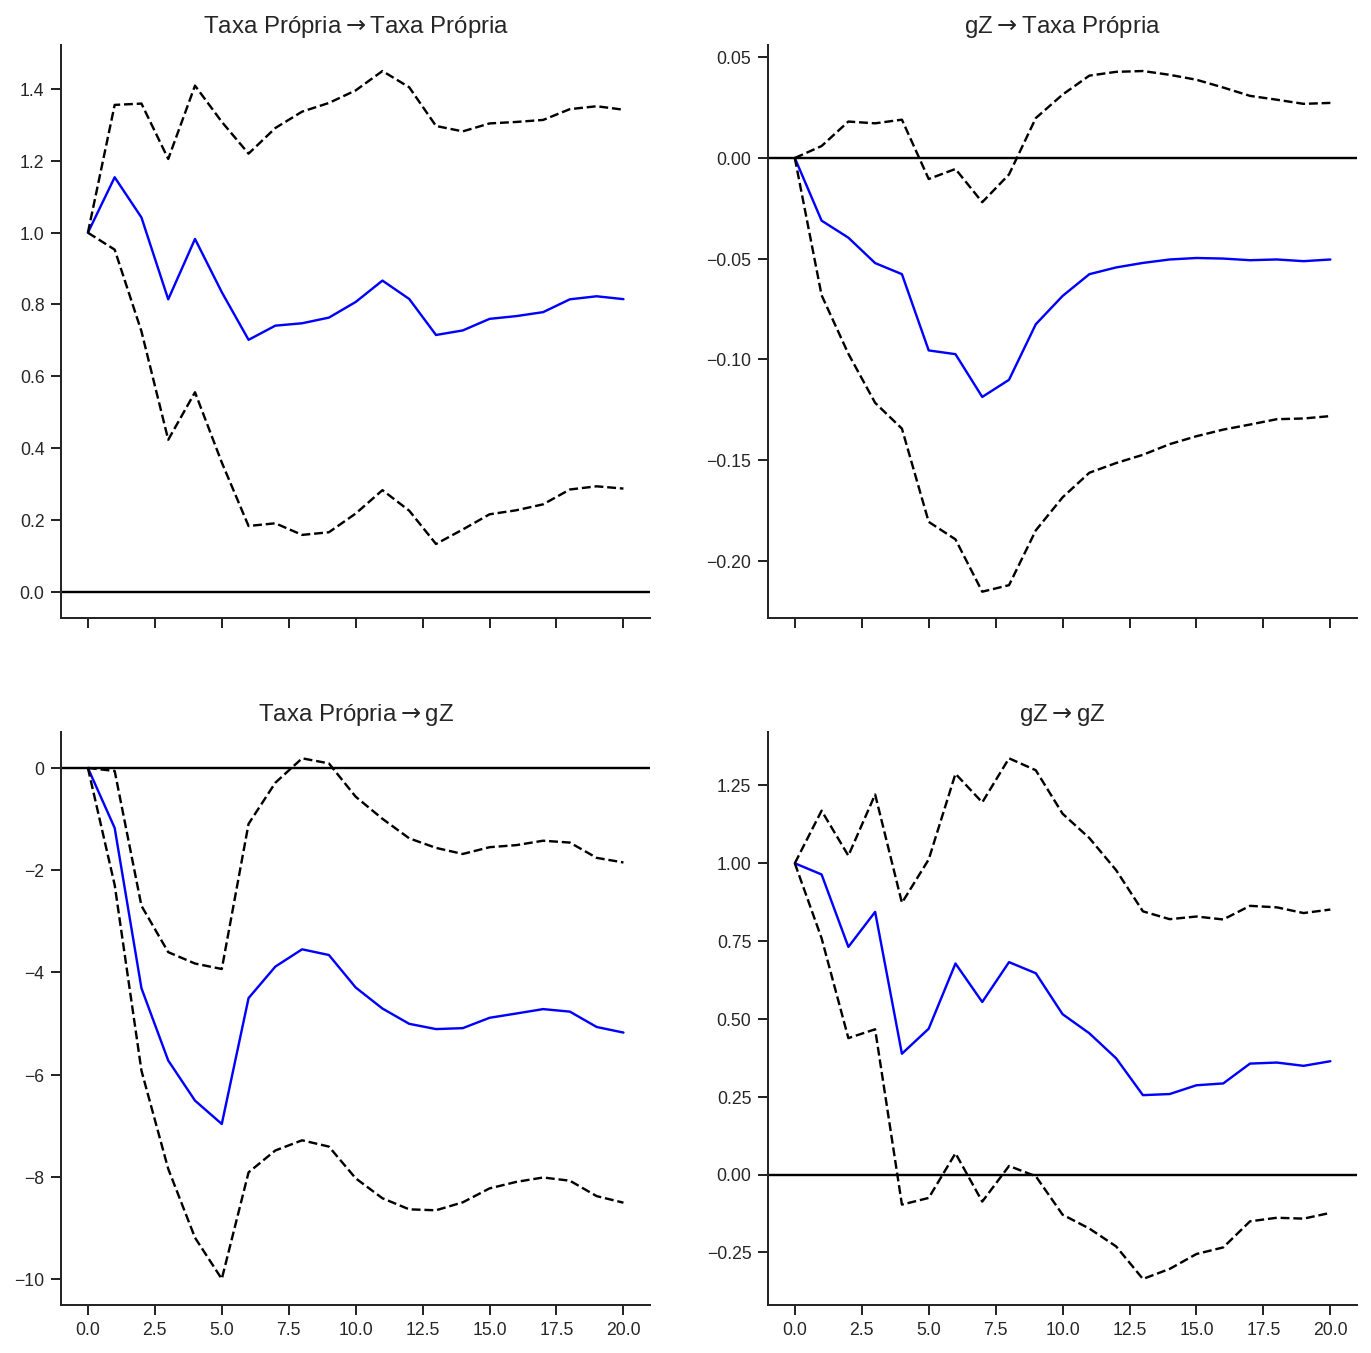

In [21]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Teste de causalidade de granger

In [22]:
series = residuals.columns
print(results.test_granger_causality(causing=series[0], caused=series[1]).summary())
print(results.test_inst_causality(causing=series[0]).summary())

Granger causality F-test. H_0: Taxa Própria does not Granger-cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         4.547          1.940   0.000 (9, 156)
----------------------------------------------
Instantaneous causality Wald-test. H_0: Taxa Própria does not instantaneously cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         8.067          3.841   0.005  1
----------------------------------------


## Inspeção gráfica dos resíduos

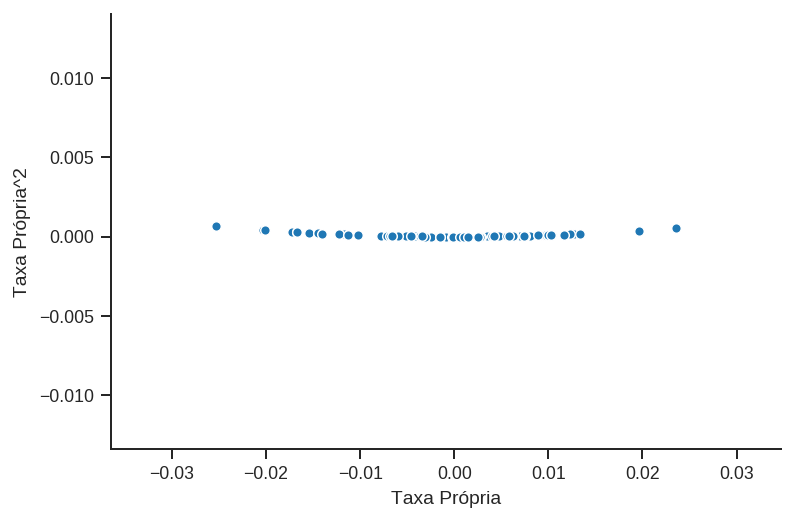

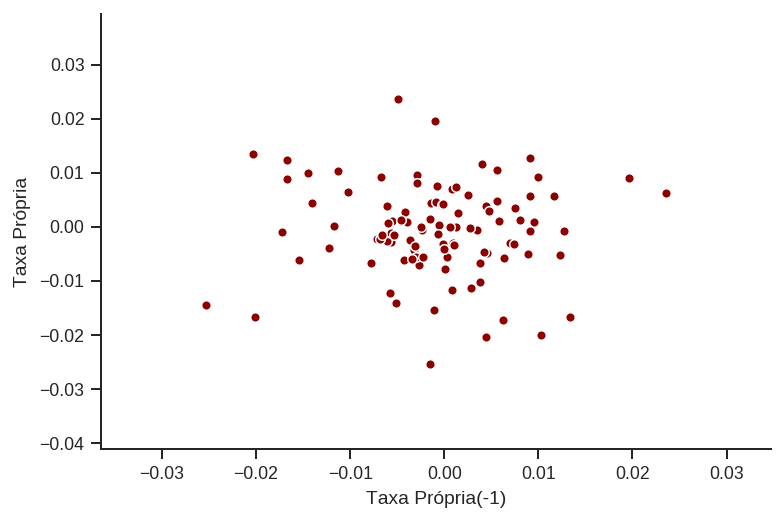

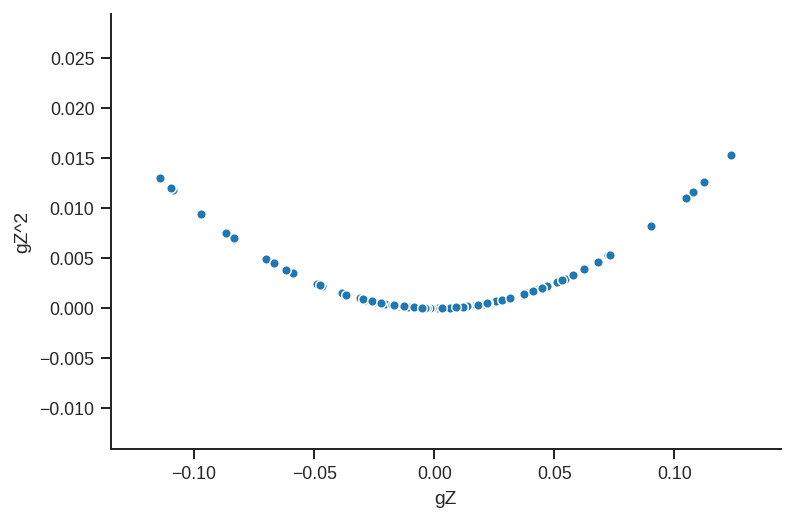

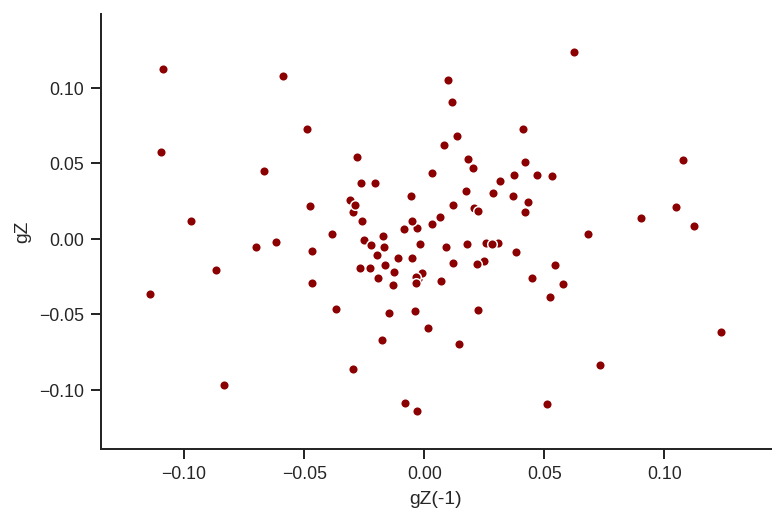

In [23]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    plt.ylabel(f"{serie}^2")
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

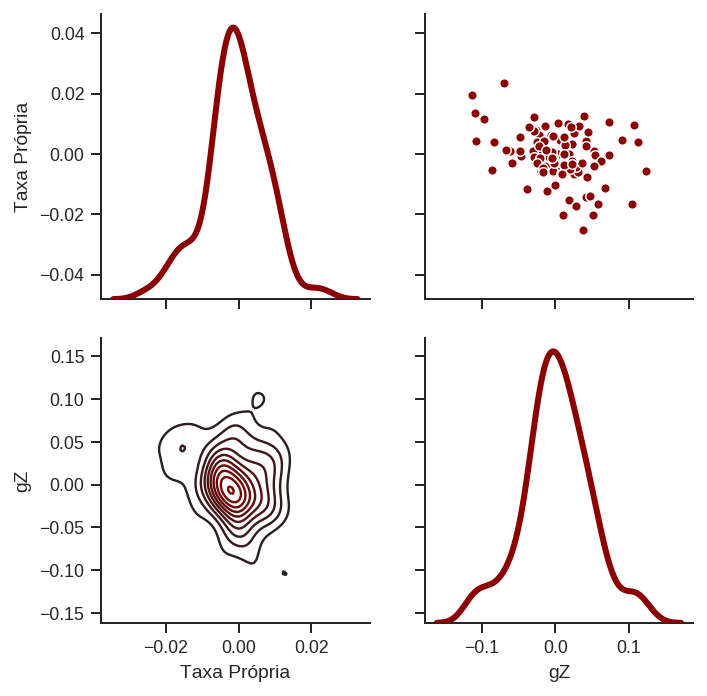

In [24]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

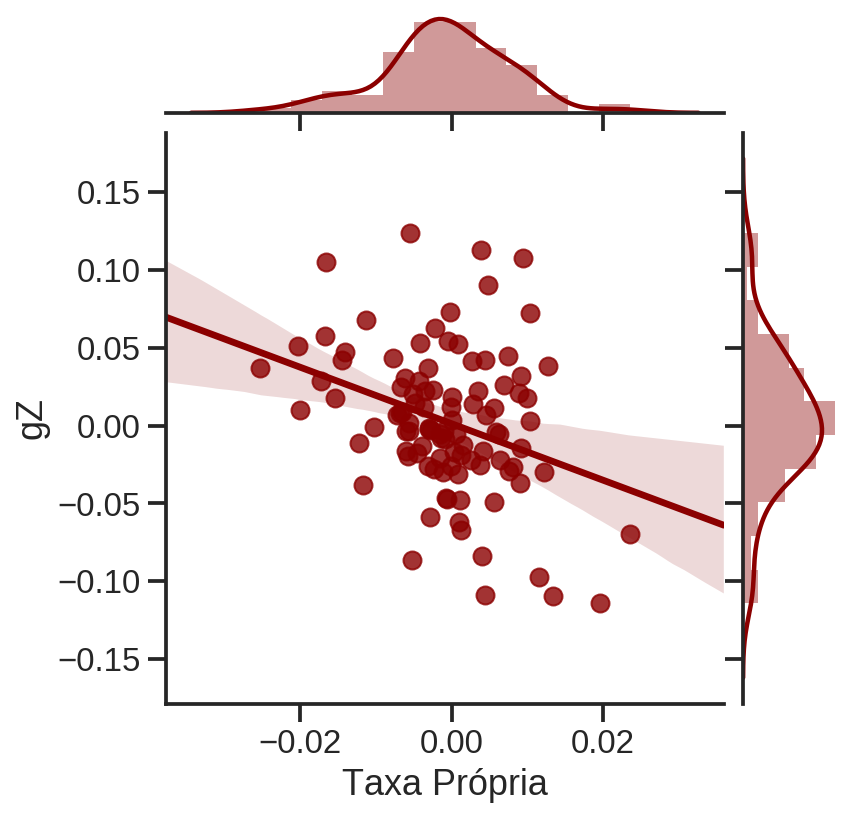

In [25]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

## FEVD

In [26]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- na.omit(df[,c("Juros", "Infla","TaxaP", "gZ")])
df <- ts(data = df, start = c(1992,03), frequency = 4)
model <- tsDyn::VECM(data = df[,c("TaxaP","gZ")], lag = 6, r = 1, estim = "ML", LRinclude="both", include="trend")
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [27]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$TaxaP)

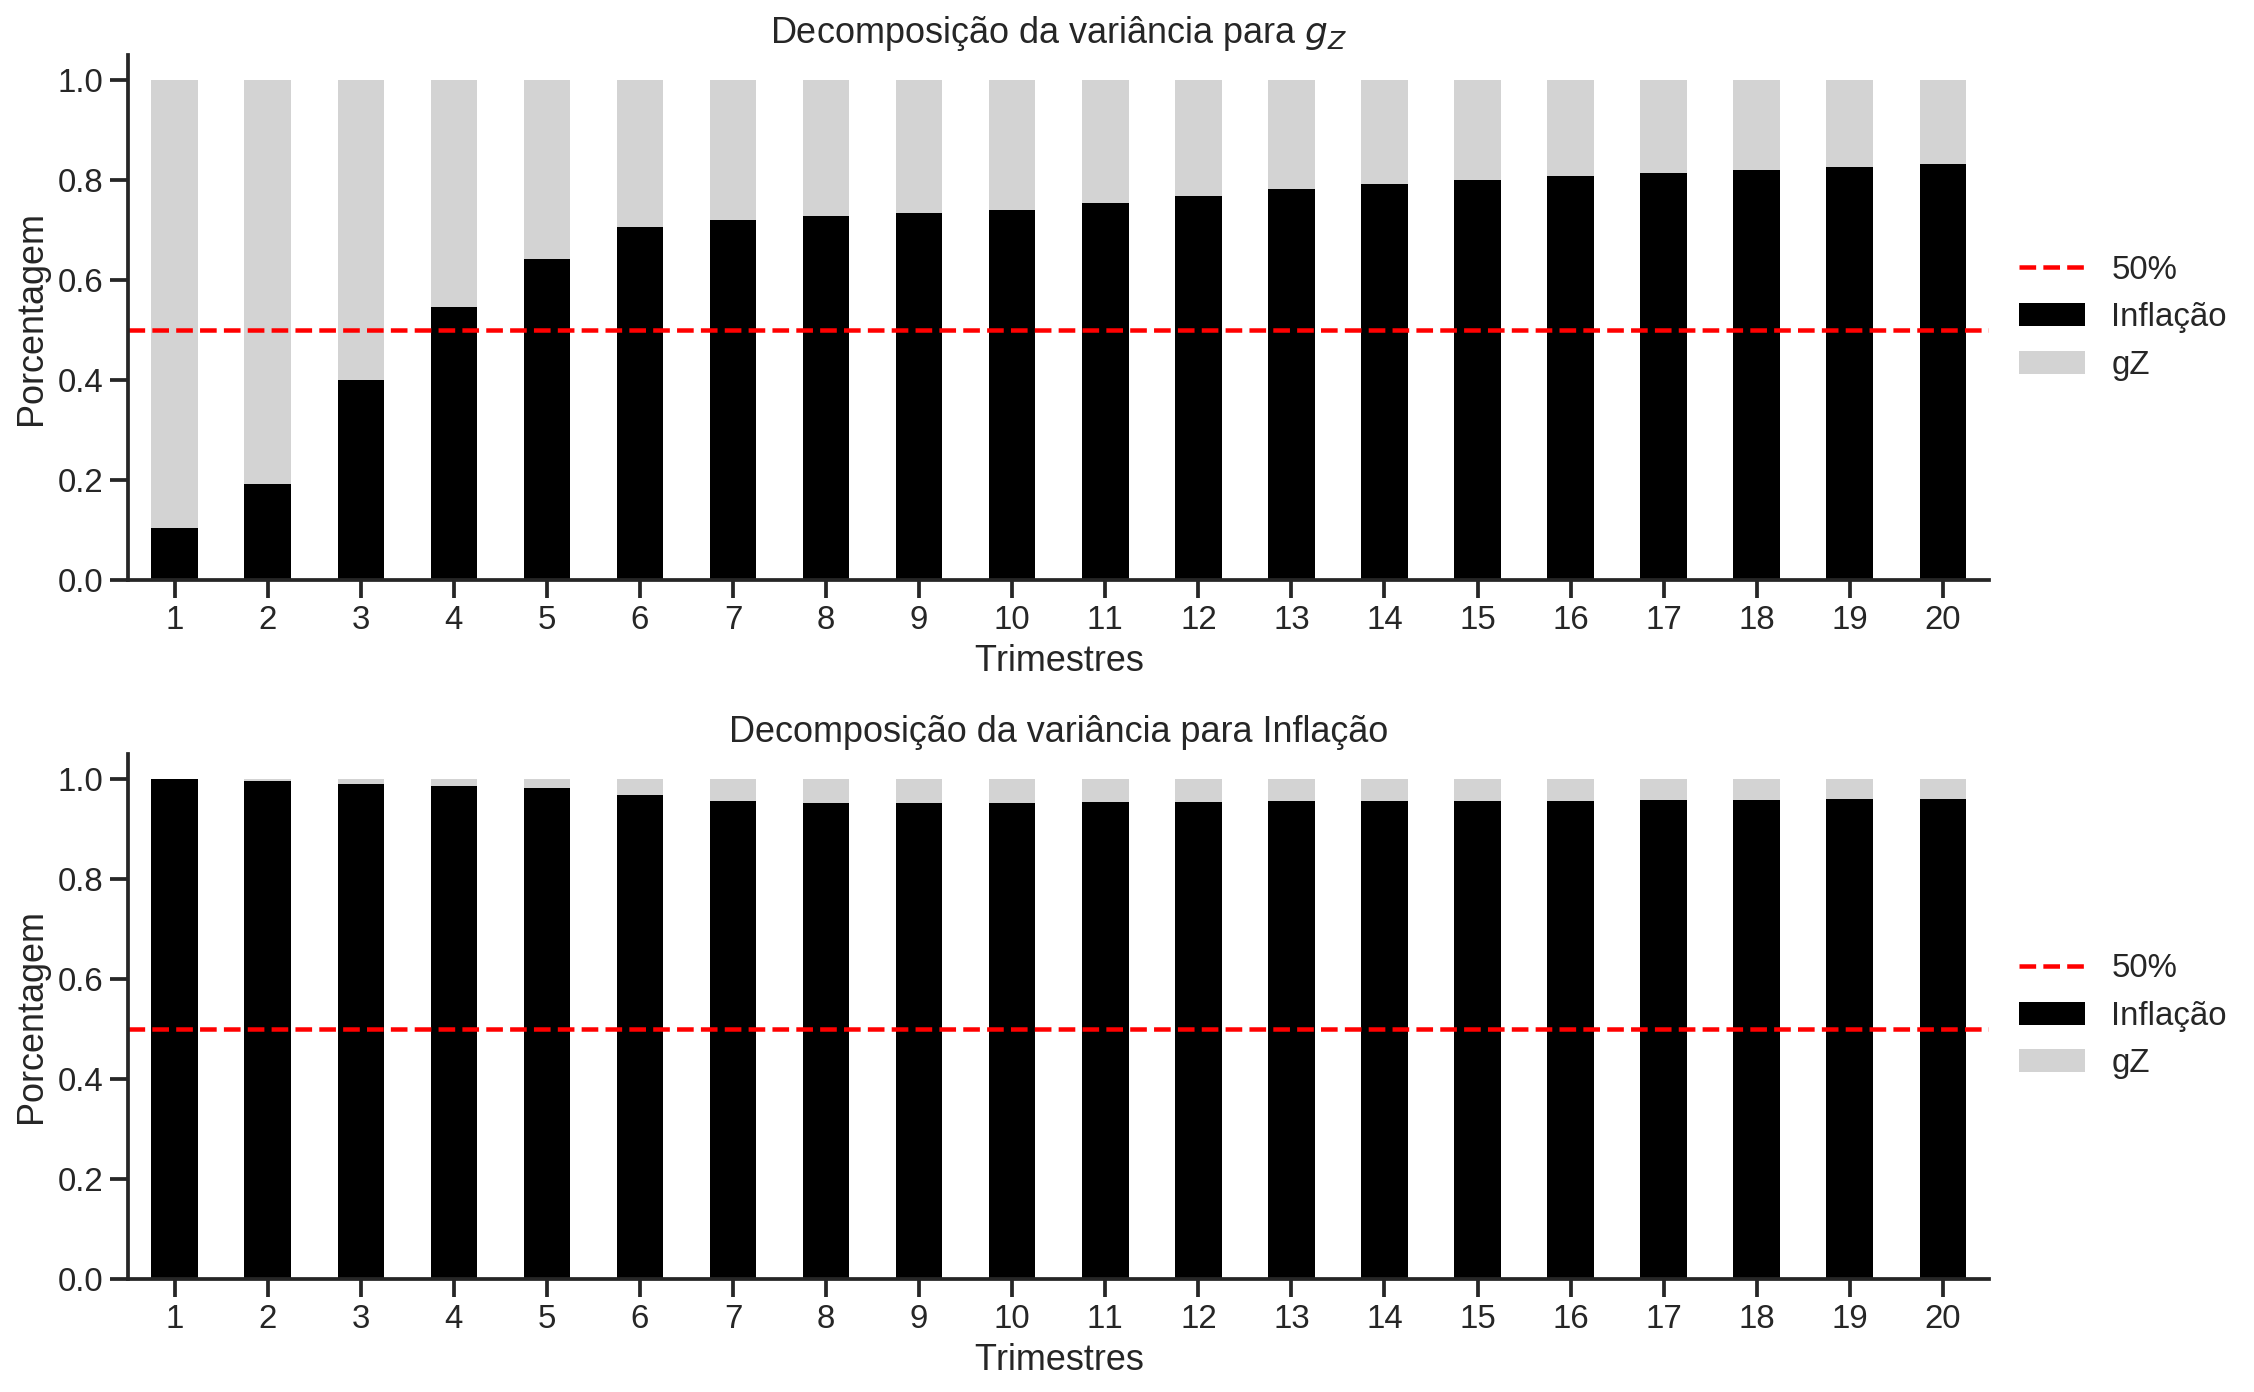

In [28]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Inflação", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

## Ordem do modelo

In [29]:
model = VAR(
    df[["d_Taxa Própria", 'd_gZ']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.80     -14.69*   3.730e-07      -14.76
1       -14.77      -14.56   3.849e-07      -14.68
2       -14.82      -14.49   3.676e-07      -14.69
3       -14.79      -14.36   3.775e-07      -14.62
4       -15.00      -14.46   3.075e-07     -14.78*
5      -15.02*      -14.37  3.011e-07*      -14.76
6       -15.02      -14.27   3.017e-07      -14.71
7       -14.97      -14.11   3.187e-07      -14.62
8       -14.96      -13.99   3.222e-07      -14.57
9       -14.89      -13.81   3.462e-07      -14.45
10      -14.84      -13.65   3.660e-07      -14.36
11      -14.83      -13.54   3.723e-07      -14.30
12      -14.79      -13.39   3.881e-07      -14.23
13      -14.82      -13.31   3.802e-07      -14.21
14      -14.75      -13.14   4.103e-07      -14.10
15      -14.78      -13.06   4.019e-07      -14.09
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [30]:
results = model.fit(maxlags=5)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           sáb, 30, nov, 2019
Time:                     11:33:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.5725
Nobs:                     105.000    HQIC:                  -14.9032
Log likelihood:           518.271    FPE:                2.69422e-07
AIC:                     -15.1285    Det(Omega_mle):     2.20748e-07
--------------------------------------------------------------------
Results for equation d_Taxa Própria
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.000777         0.000941           -0.826           0.409
L1.d_Taxa Própria         0.191503         0.103345            1.853           0.064
L1.d_gZ                  -0.016181 

## Pós-estimação

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

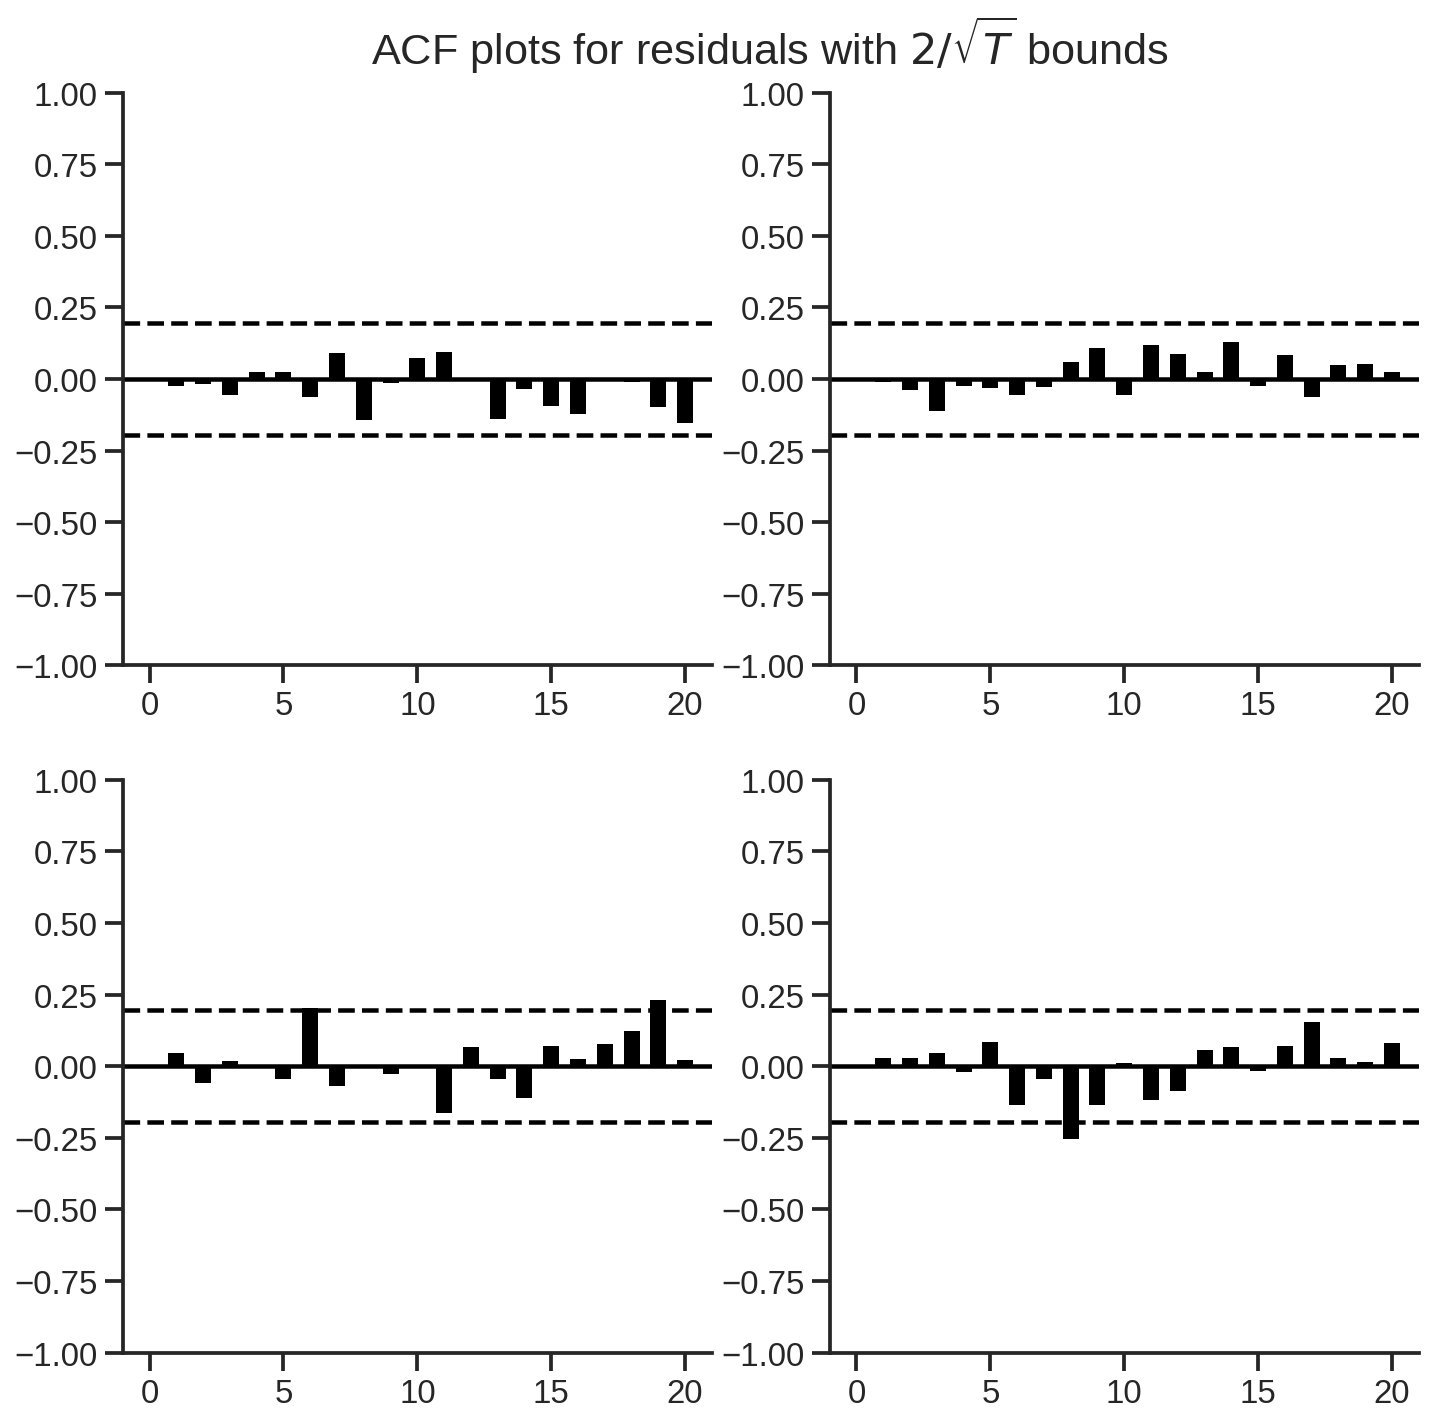

In [31]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação serial dos resíduos.

### Estabilidade

In [32]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.7952196047128628
0.8274111916556438
0.8274111916556438
0.7575379610838274
0.7575379610838274
0.8737013141613541
0.8737013141613541
0.5525176483885951
0.47829483288915725
0.47829483288915725
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

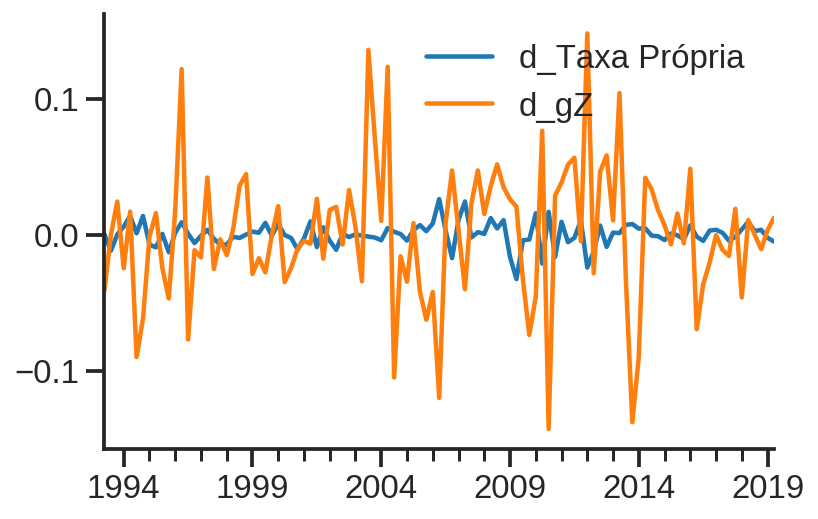

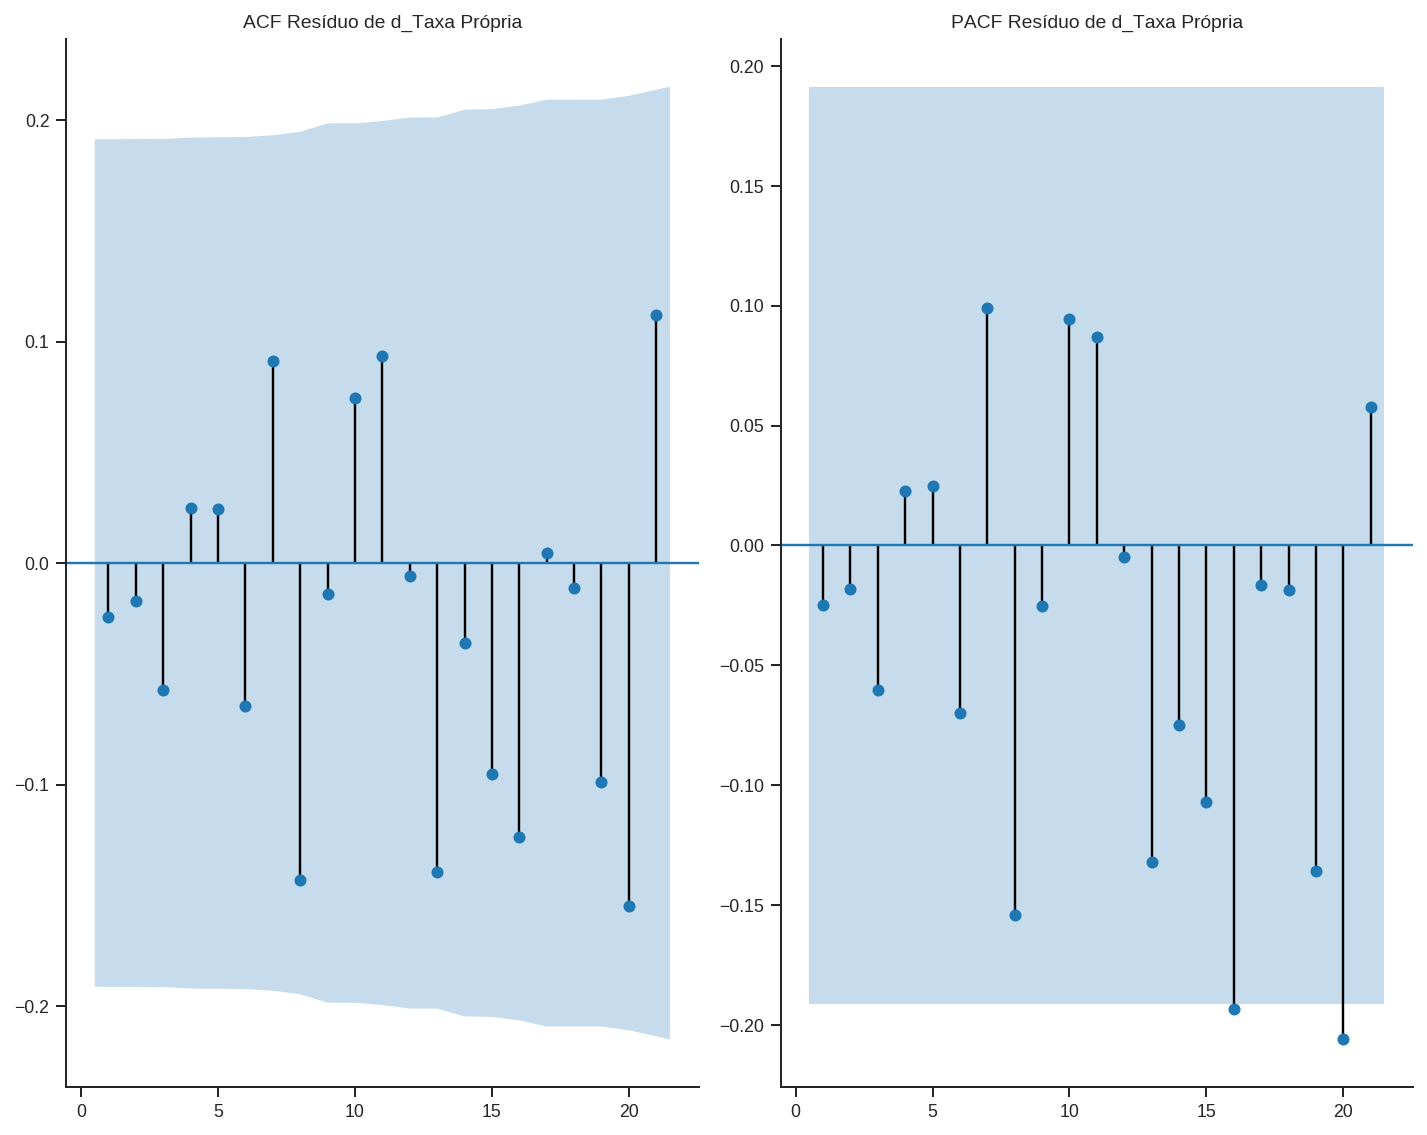

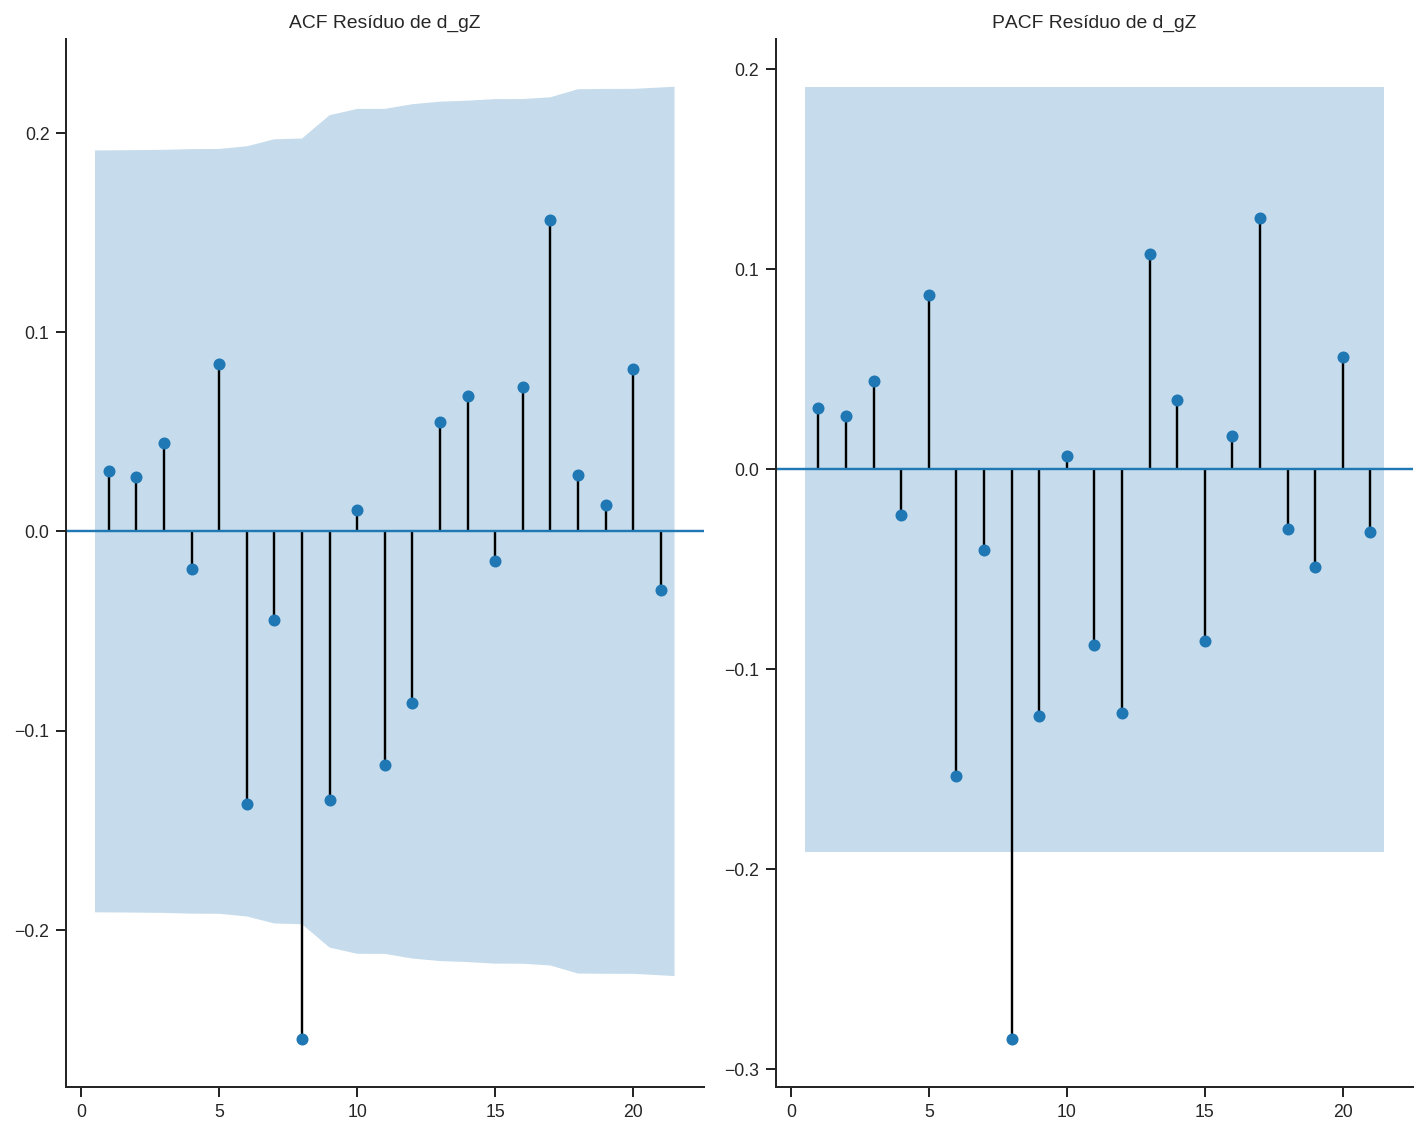

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         44.22          55.76   0.298 40
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         48.46          55.76   0.169 40
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_TAXA PRÓPRIA . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3

In [33]:
residuals = analise_residuos(results=results)

## Inspeção gráfica dos resíduos

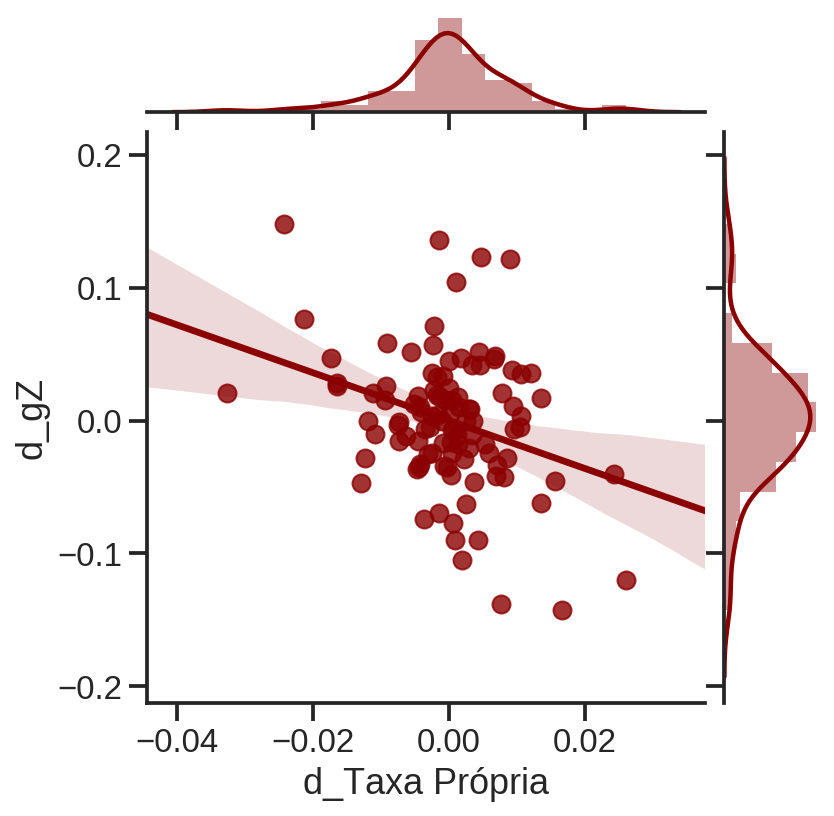

In [34]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

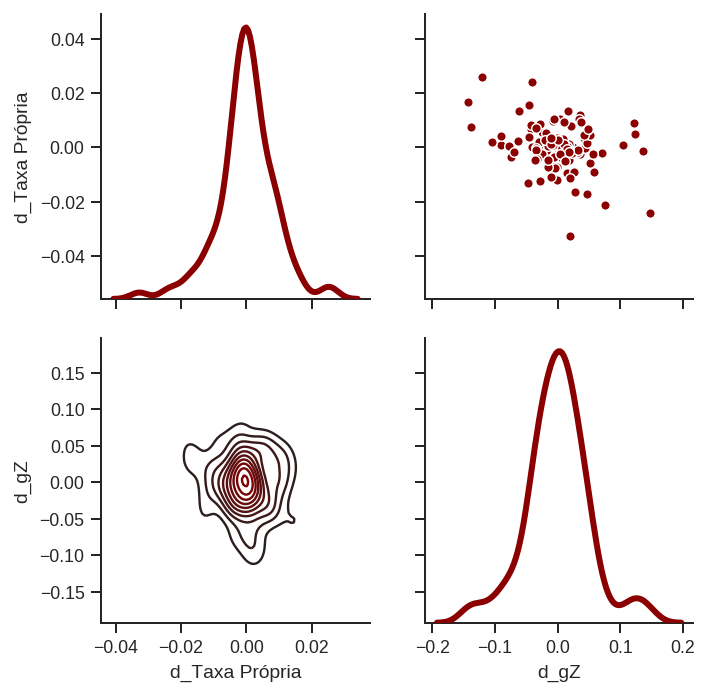

In [35]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

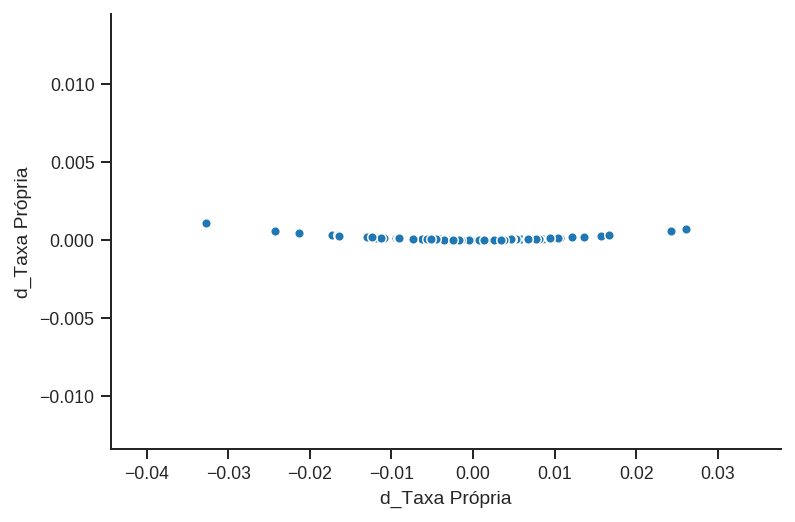

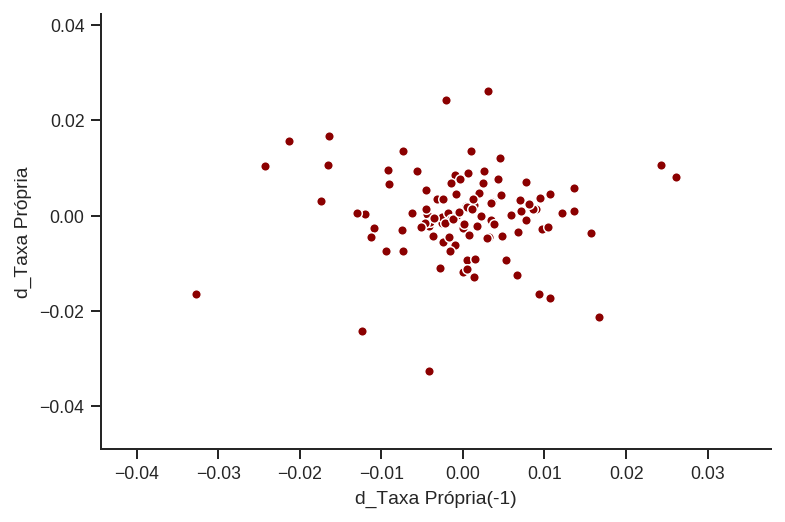

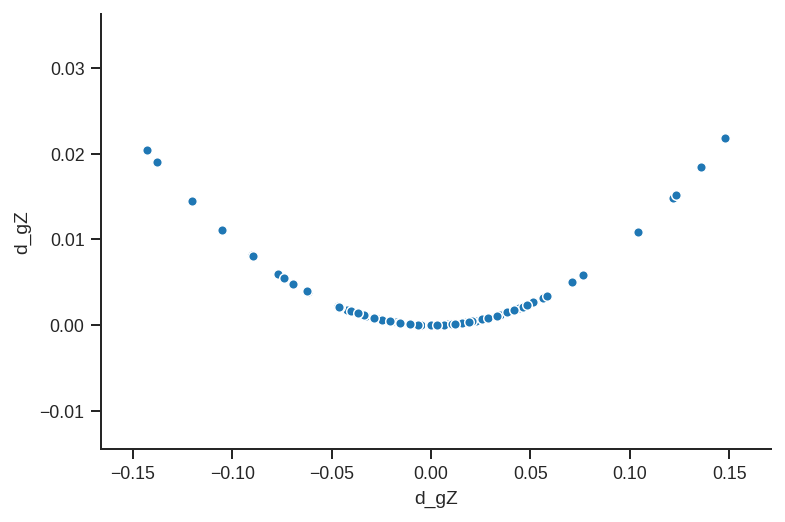

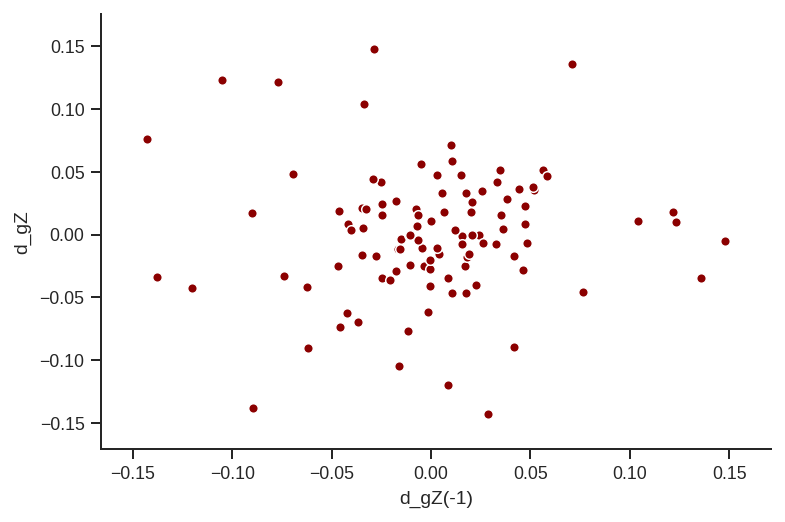

In [36]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

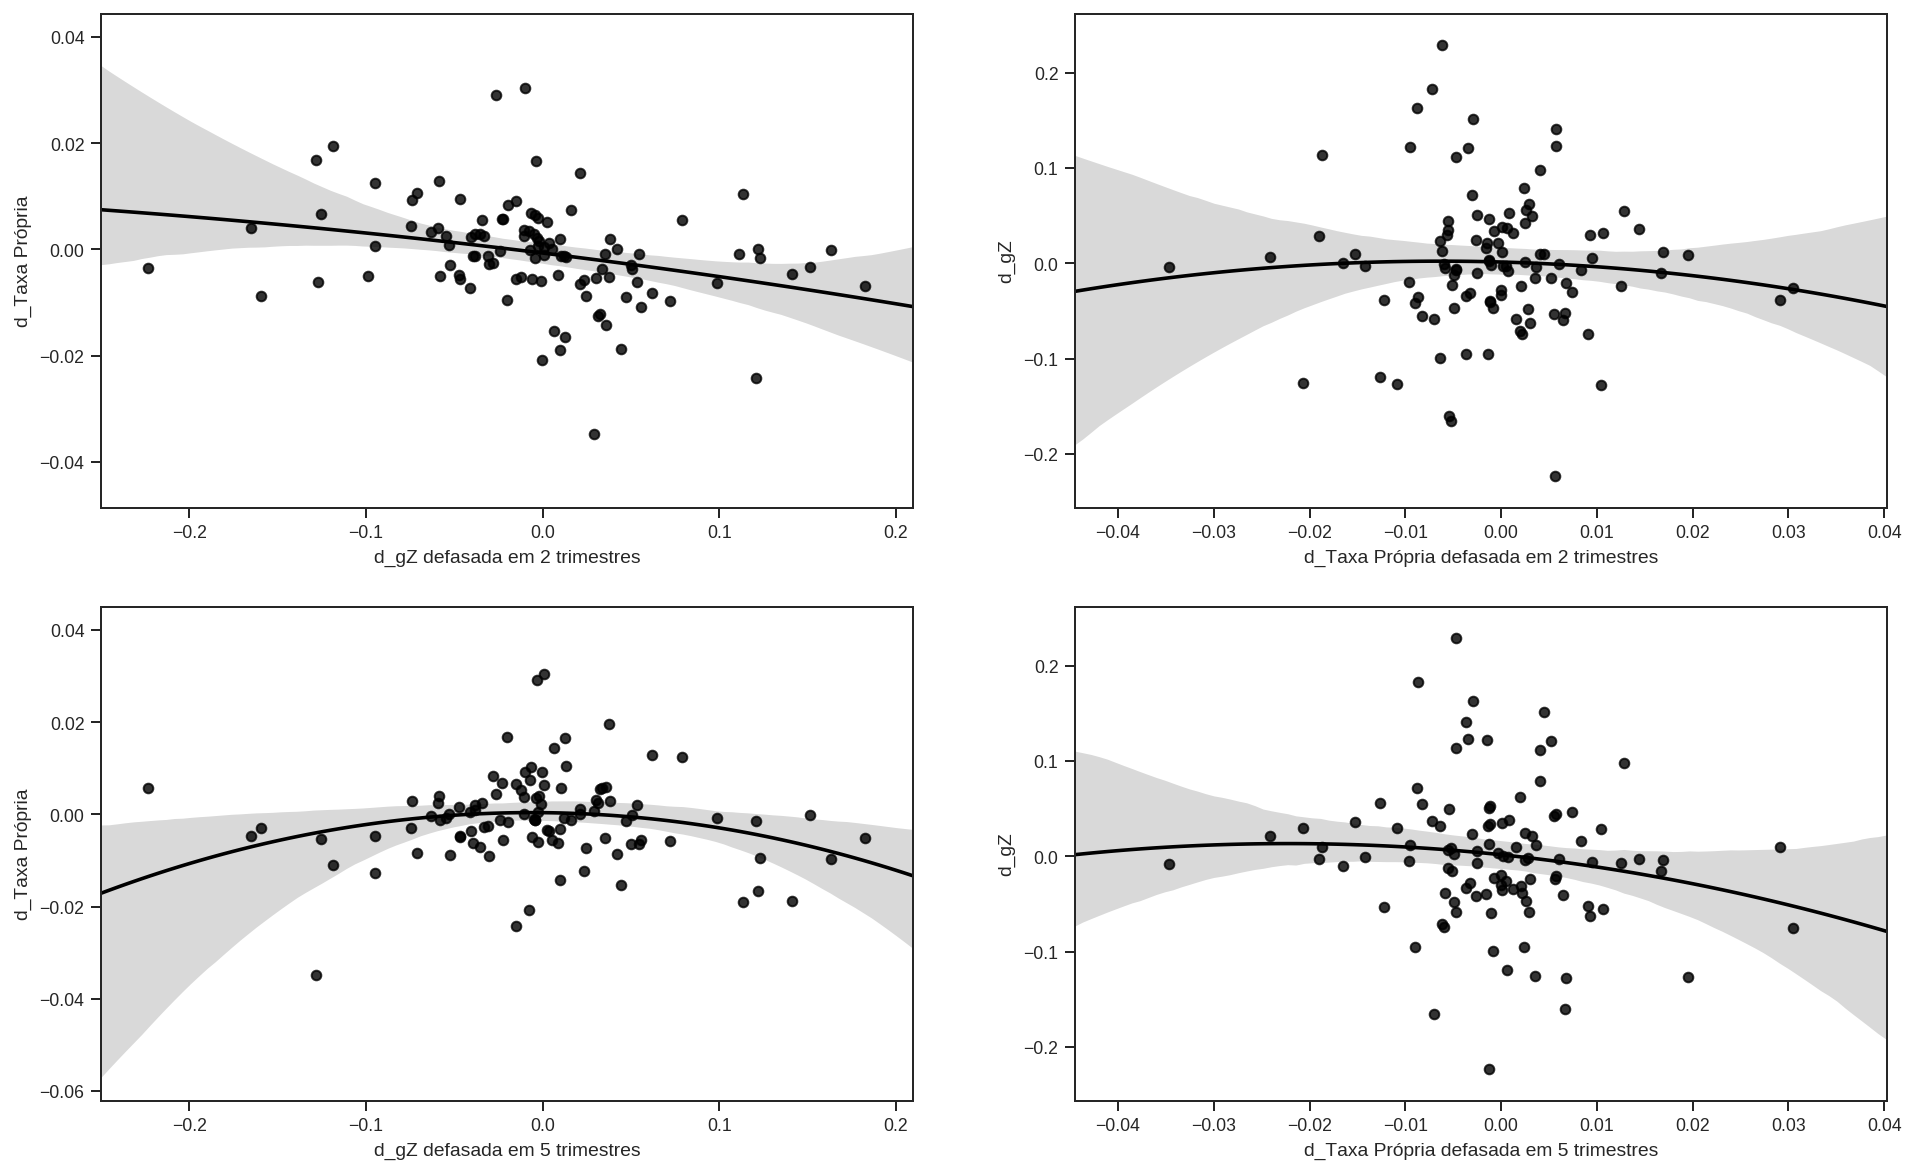

In [37]:
plot_lags(results=results)

## Função resposta ao impulso ortogonalizada

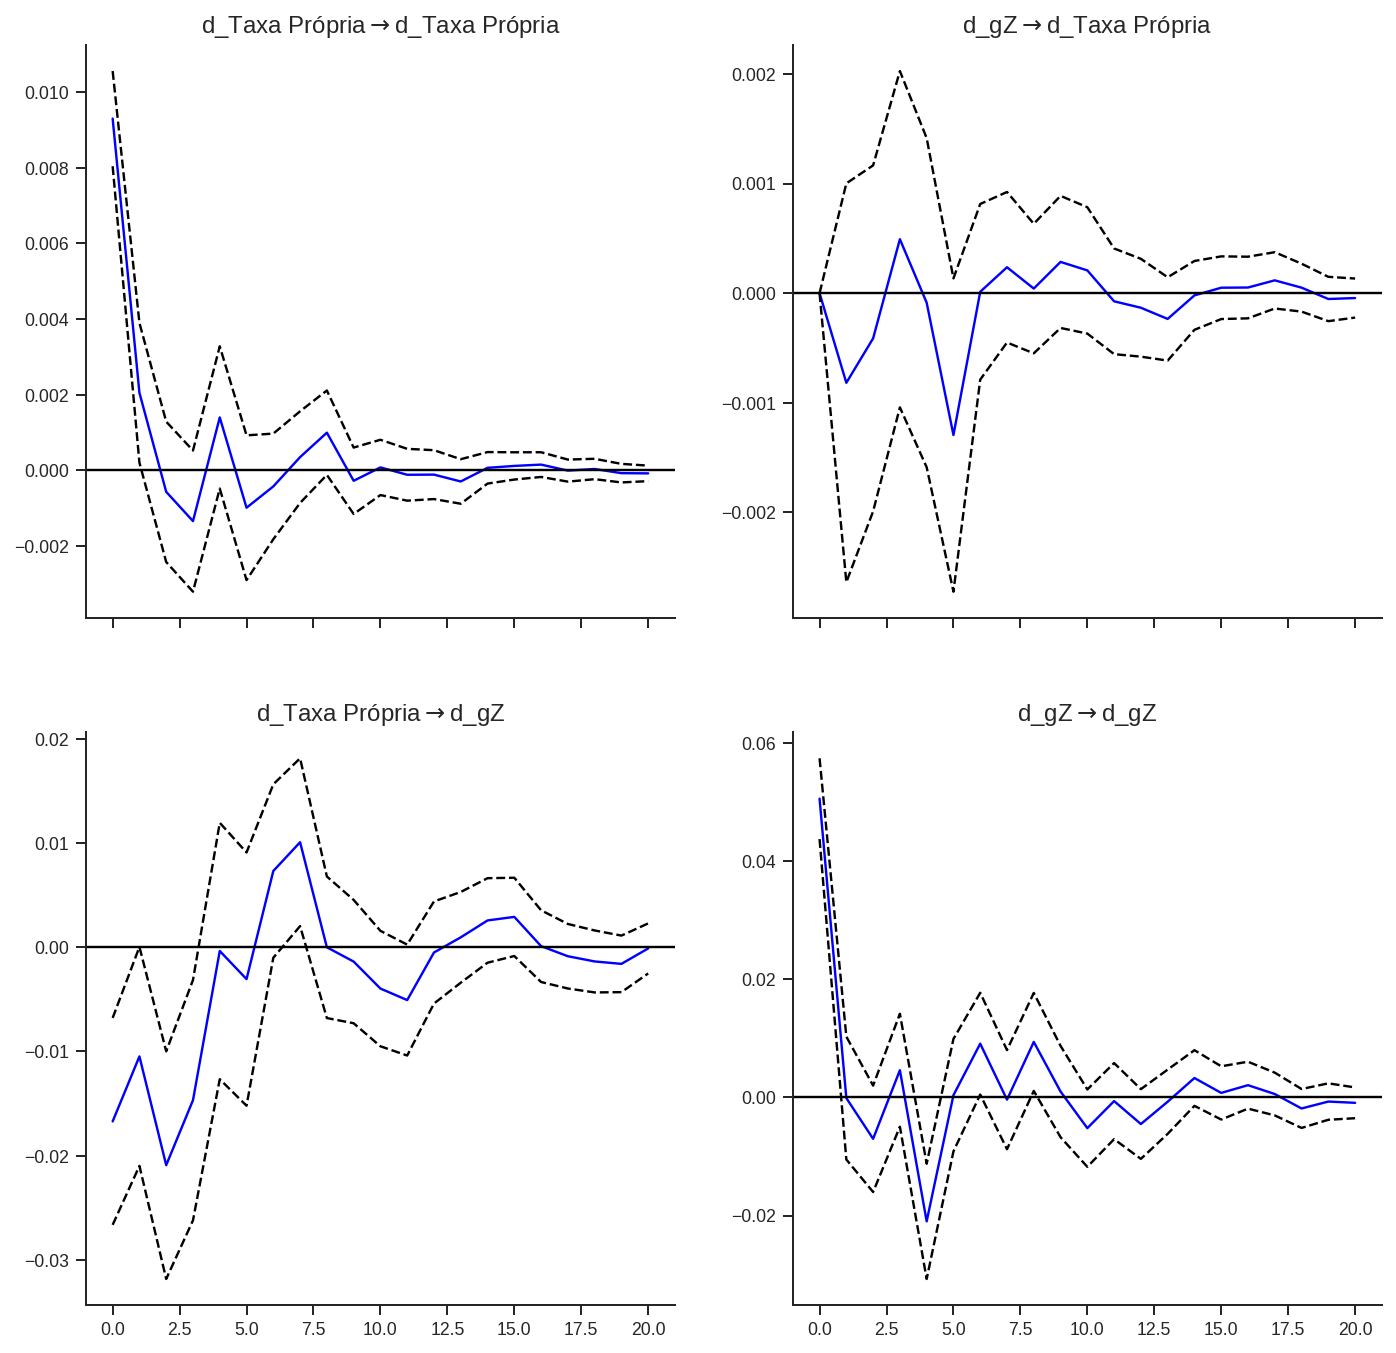

In [38]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

## Função resposta ao impulso não-ortogonalizada

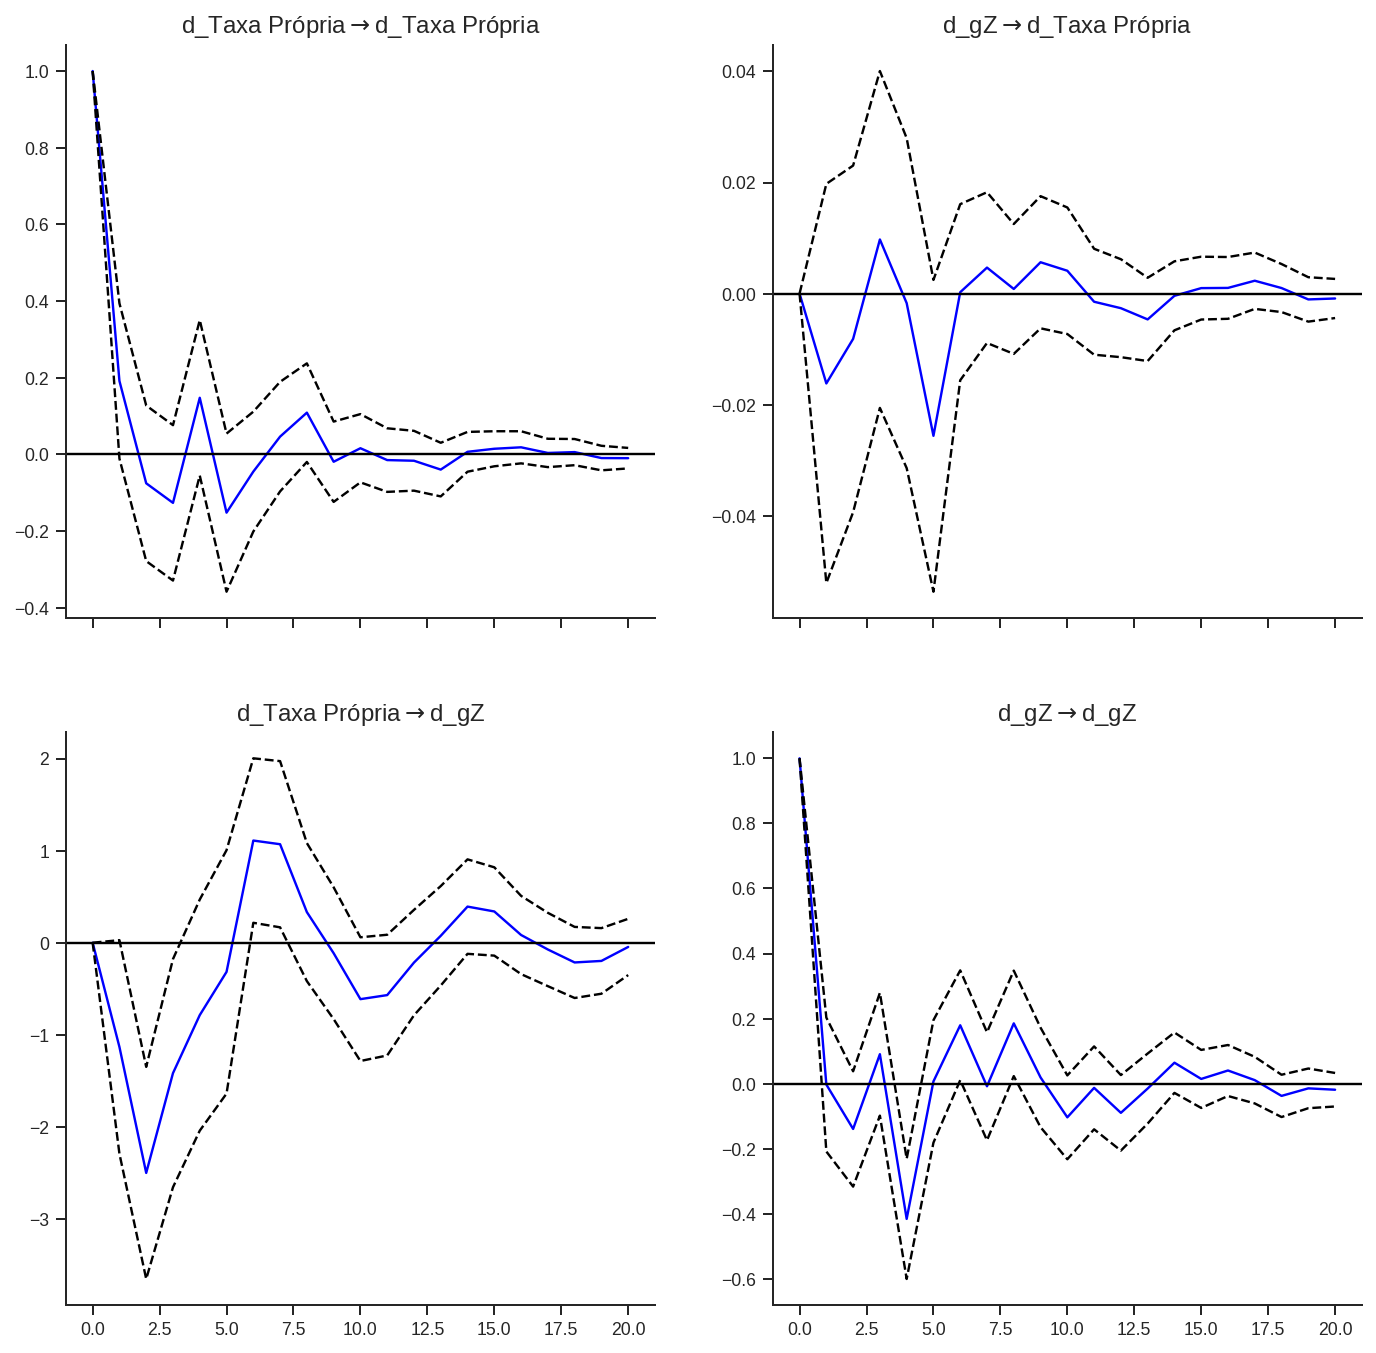

In [39]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

## Efeito cumulativo

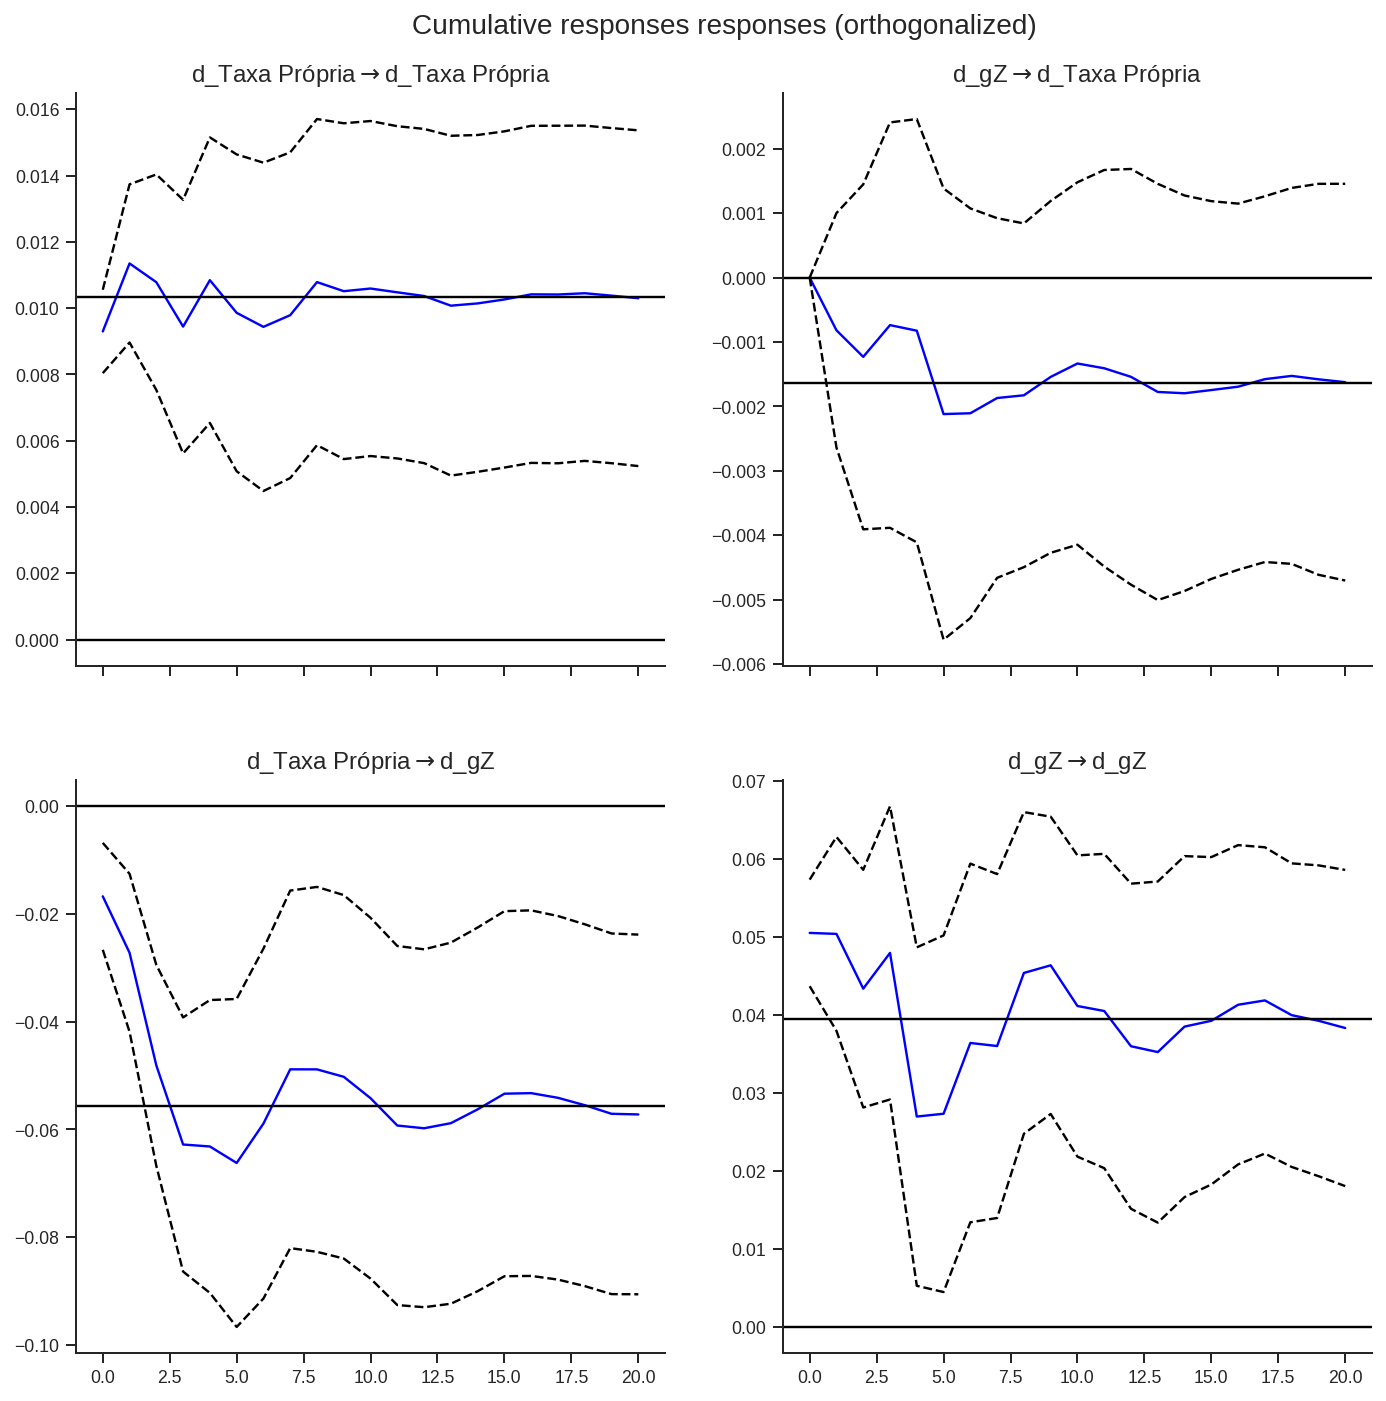

In [40]:
p = results.irf(20).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

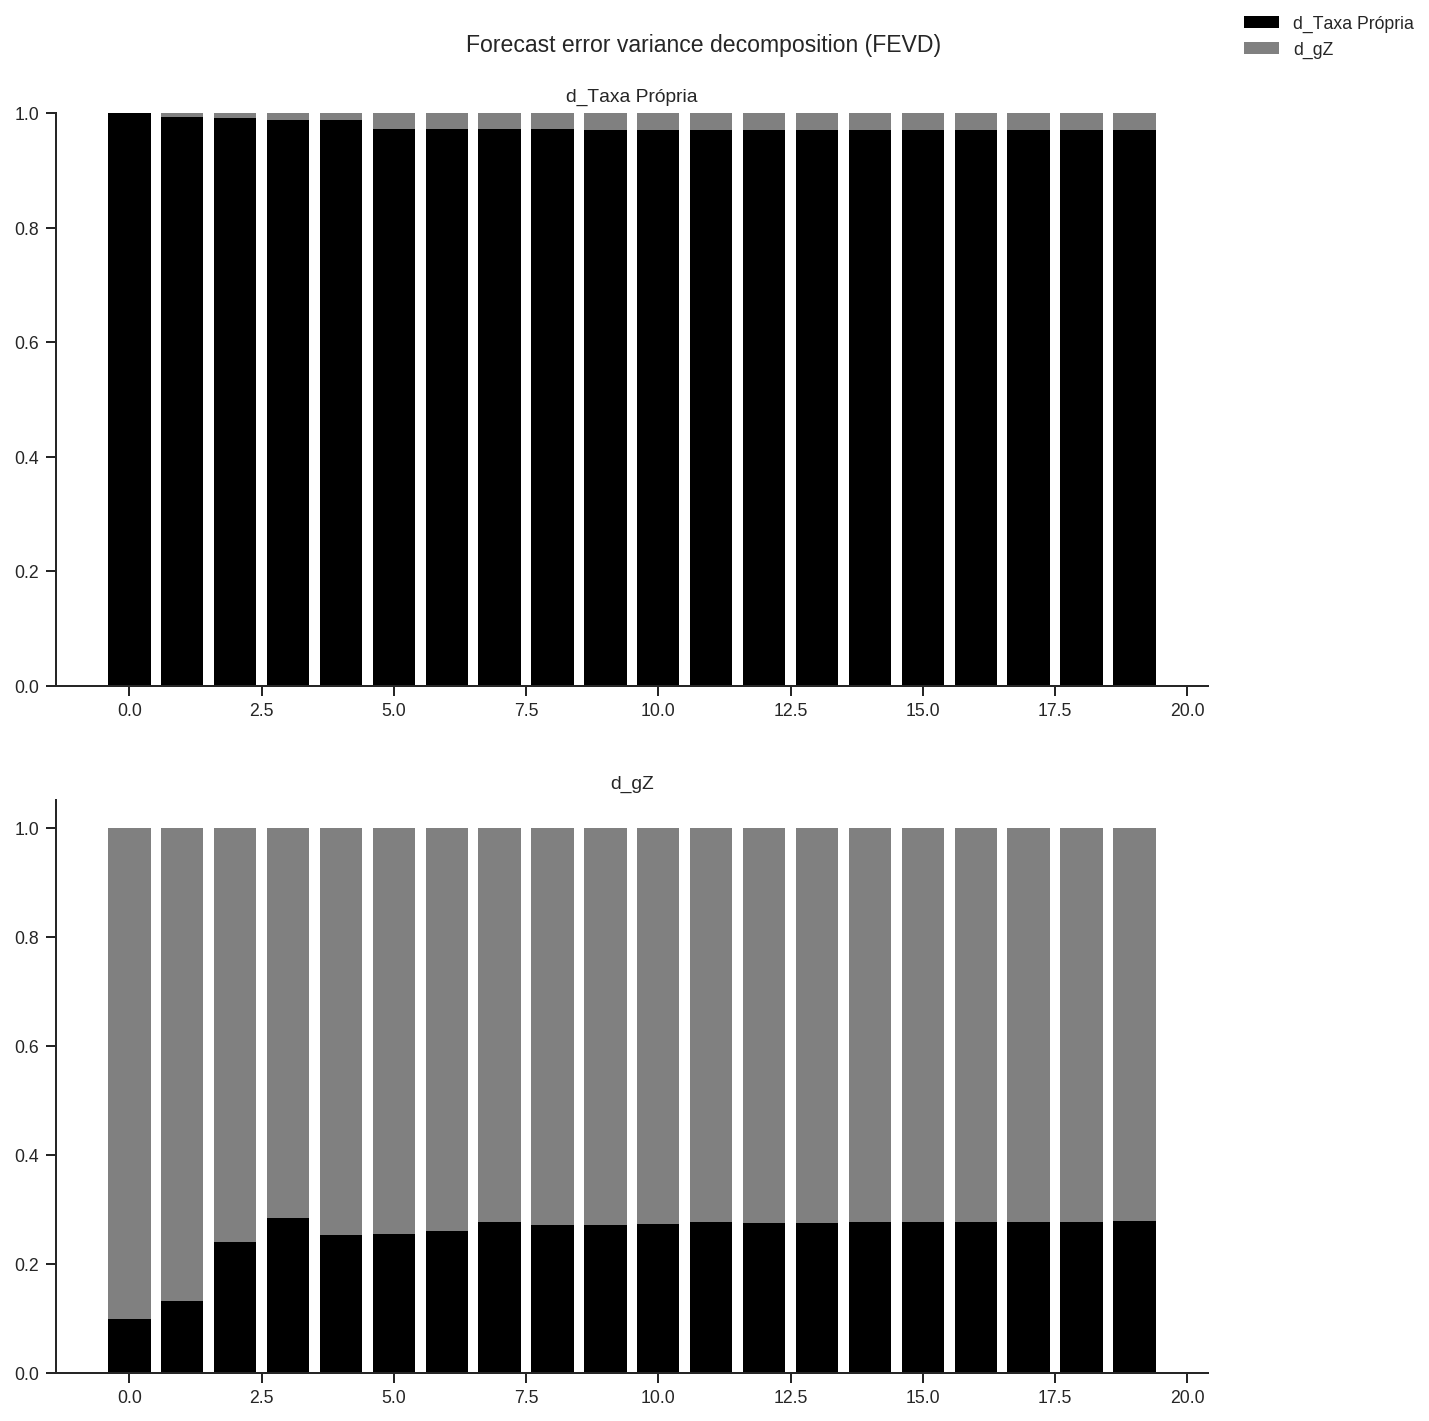

In [41]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)